# [Maureen] Inftrain ABX Analysis

## Includes bilingual data

In [1]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import seaborn as sns

#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower

sns.set_theme()

HOME="/linkhome/rech/genini01/ucv88ce/"
models_path=os.path.join(HOME,"projects/MultilingualCPC/experiments/checkpoints/inftrain" )
eval_path=""

* Functions definition

In [2]:
def retrieve_scores( size= [50,100, 200, 400, 800], abx_type="both", easyfilter = False, models_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/eval/inftrain'):
    fam_dict={}

    #columns = fam_id 	size 	eval_lang 	en_model 	fr_model 	bil_totalsize_A 	bil_totalsize_B 	same 	different 	bil_langsize 	bil_totalsize 	mono_avg (same and diff are just the scores from tje model corresponding to th train and eval)
    #do average of within and across
    langs=["EN","FR","EN+FR"]
    #langs=["EN","FR","EN+FR.bk"]

    for s in sorted(size):
        s=int(s)
        for fam in ["{}".format(str(x).zfill(2)) for x in range(int(32/s*100))] :

            for eval_lang in ['en','fr']:
                k = fam+"_"+eval_lang+"_"+str(s)

                values = [fam, int(s), eval_lang]

                for model in langs:
                    
                    if model == "EN" or model == "FR" :
                        
                        path = os.path.join(models_path,model,str(s)+"h",fam,"cpc_small/ABX","**",eval_lang, "ABX_scores.json")
                        json_f = glob(path, recursive=True)
                        if easyfilter : 
                            json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                        else:
                            json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                        
                        if len(json_f) > 1:
                            json_f = [max(json_f, key=os.path.getctime)]

                        if not json_f :
                            score = np.nan
                        else:
                            with open(json_f[0], "r") as f:

                                scores = json.load(f)
                            if abx_type == "both" :
                                score = np.mean([scores['within'],scores['across']]) * 100
                            else :
                                score = scores[abx_type]*100
                        values.append(score)

                    elif model == "EN+FR" :
                        bil_scores = []
                        for bil_fam in [str(int(fam)*2).zfill(2), str((int(fam)*2) + 1).zfill(2)] :
                            path = os.path.join(models_path,model,str(s)+"h",bil_fam,"cpc_small/ABX","**","cv_test", eval_lang, eval_lang,"ABX_scores.json")
                            json_f = glob(path, recursive=True)
                            
                            
                            if easyfilter : 
                                json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                            else:
                                json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                                                        
                            if len(json_f) > 1:
                                
                                json_f = [max(json_f, key=os.path.getctime)]

                            if not json_f :
                                score = np.nan
                            else:
                                with open(json_f[0], "r") as f:
                                    scores = json.load(f)
                                if abx_type == "both" :
                                    score = np.mean([scores['within'],scores['across']]) * 100
                                else :
                                    score = scores[abx_type]*100 
                                    
                            values.append(score)
                            
                            #below add langsize
                            if fam+"_"+eval_lang+"_"+str(int(s/2)) in fam_dict :
                                fam_dict[bil_fam+"_"+eval_lang+"_"+str(int(s/2))][-1] = score


                        
                    if model == "EN" and eval_lang == "en" :
                        same = score
                    elif model == "EN" and eval_lang == "fr" :
                        different = score
                    elif model == "FR" and eval_lang == "fr" :
                        same = score
                    elif model == "FR" and eval_lang == "en" :
                        different = score

                values.append(same)
                values.append(different)
                values.append(np.nan) #eate space for the "bil_add"
                fam_dict[k] = values
                


    

    df = pd.DataFrame.from_dict(fam_dict, orient='index', columns=["fam_id", "size", "eval_lang", "en_model", "fr_model", "bil_totalsize_A", "bil_totalsize_B", 'same', 'different', "bil_langsize"])
    df['bil_totalsize'] = df[["bil_totalsize_A", "bil_totalsize_B"]].mean(axis=1)
    df["mono_avg"] = df[["en_model", "fr_model"]].mean(axis=1)
    return df

## Retrieve ABX scores & datasets

*MDS - Todo : add lambda function to systematically retrieve latest checkpoint ABX score*

1. df_within : original ABX scores calculated "within speaker"
2. df_across : original ABX scores calculated "across speakers"
3. df_ef_within : "easyfilter" ABX scores calculated "within speaker"
4. df_ef_across : "easyfilter" ABX scores calculated "across speakers"


The "easyfilter" abx scores correspond, for the french scores, to the scores calculated on the "quickfix" item files (see [Google Document](https://docs.google.com/document/d/1XoGX52rBFOwue2twX02IuEhO_-ZktSZh-qdvpuBqK3I/edit?usp=sharing)). The english scores are the same as the original ones. 

In [3]:
abx_type="both"
abx_type="within"


df_within = retrieve_scores(abx_type="within")
df_within_size = df_within.groupby(by="size").mean()

df_across = retrieve_scores(abx_type="across")
df_across_size = df_across.groupby(by="size").mean()

In [4]:
df_within

,fam_id,size,eval_lang,en_model,fr_model,bil_totalsize_A,bil_totalsize_B,same,different,bil_langsize,bil_totalsize,mono_avg
00_en_50,00,50,en,8.880042,9.540319,NaN,NaN,8.880042,9.540319,8.745991,NaN,9.210180
00_fr_50,00,50,fr,8.580861,8.297460,NaN,NaN,8.297460,8.580861,7.891306,NaN,8.439161
01_en_50,01,50,en,8.976586,9.703365,NaN,NaN,8.976586,9.703365,8.705667,NaN,9.339976
01_fr_50,01,50,fr,8.708234,8.145186,NaN,NaN,8.145186,8.708234,7.742734,NaN,8.426710
02_en_50,02,50,en,9.578168,9.888531,NaN,NaN,9.578168,9.888531,9.559481,NaN,9.733349
...,...,...,...,...,...,...,...,...,...,...,...,...
01_fr_800,01,800,fr,6.724393,5.938469,6.282429,6.061646,5.938469,6.724393,NaN,6.172037,6.331431
02_en_800,02,800,en,6.206650,7.818012,7.223161,7.354549,6.206650,7.818012,NaN,7.288855,7.012331
02_fr_800,02,800,fr,6.348864,6.352817,6.176079,6.425199,6.352817,6.348864,NaN,6.300639,6.350841
03_en_800,03,800,en,6.678519,8.079922,7.836702,7.635270,6.678519,8.079922,NaN,7.735986,7.379221


# Figures

## A. Boxplots of ABX scores in function of training size for the different model types

### A1 - ABX across speakers - original
- Test set : average of French and English
- Df : Original

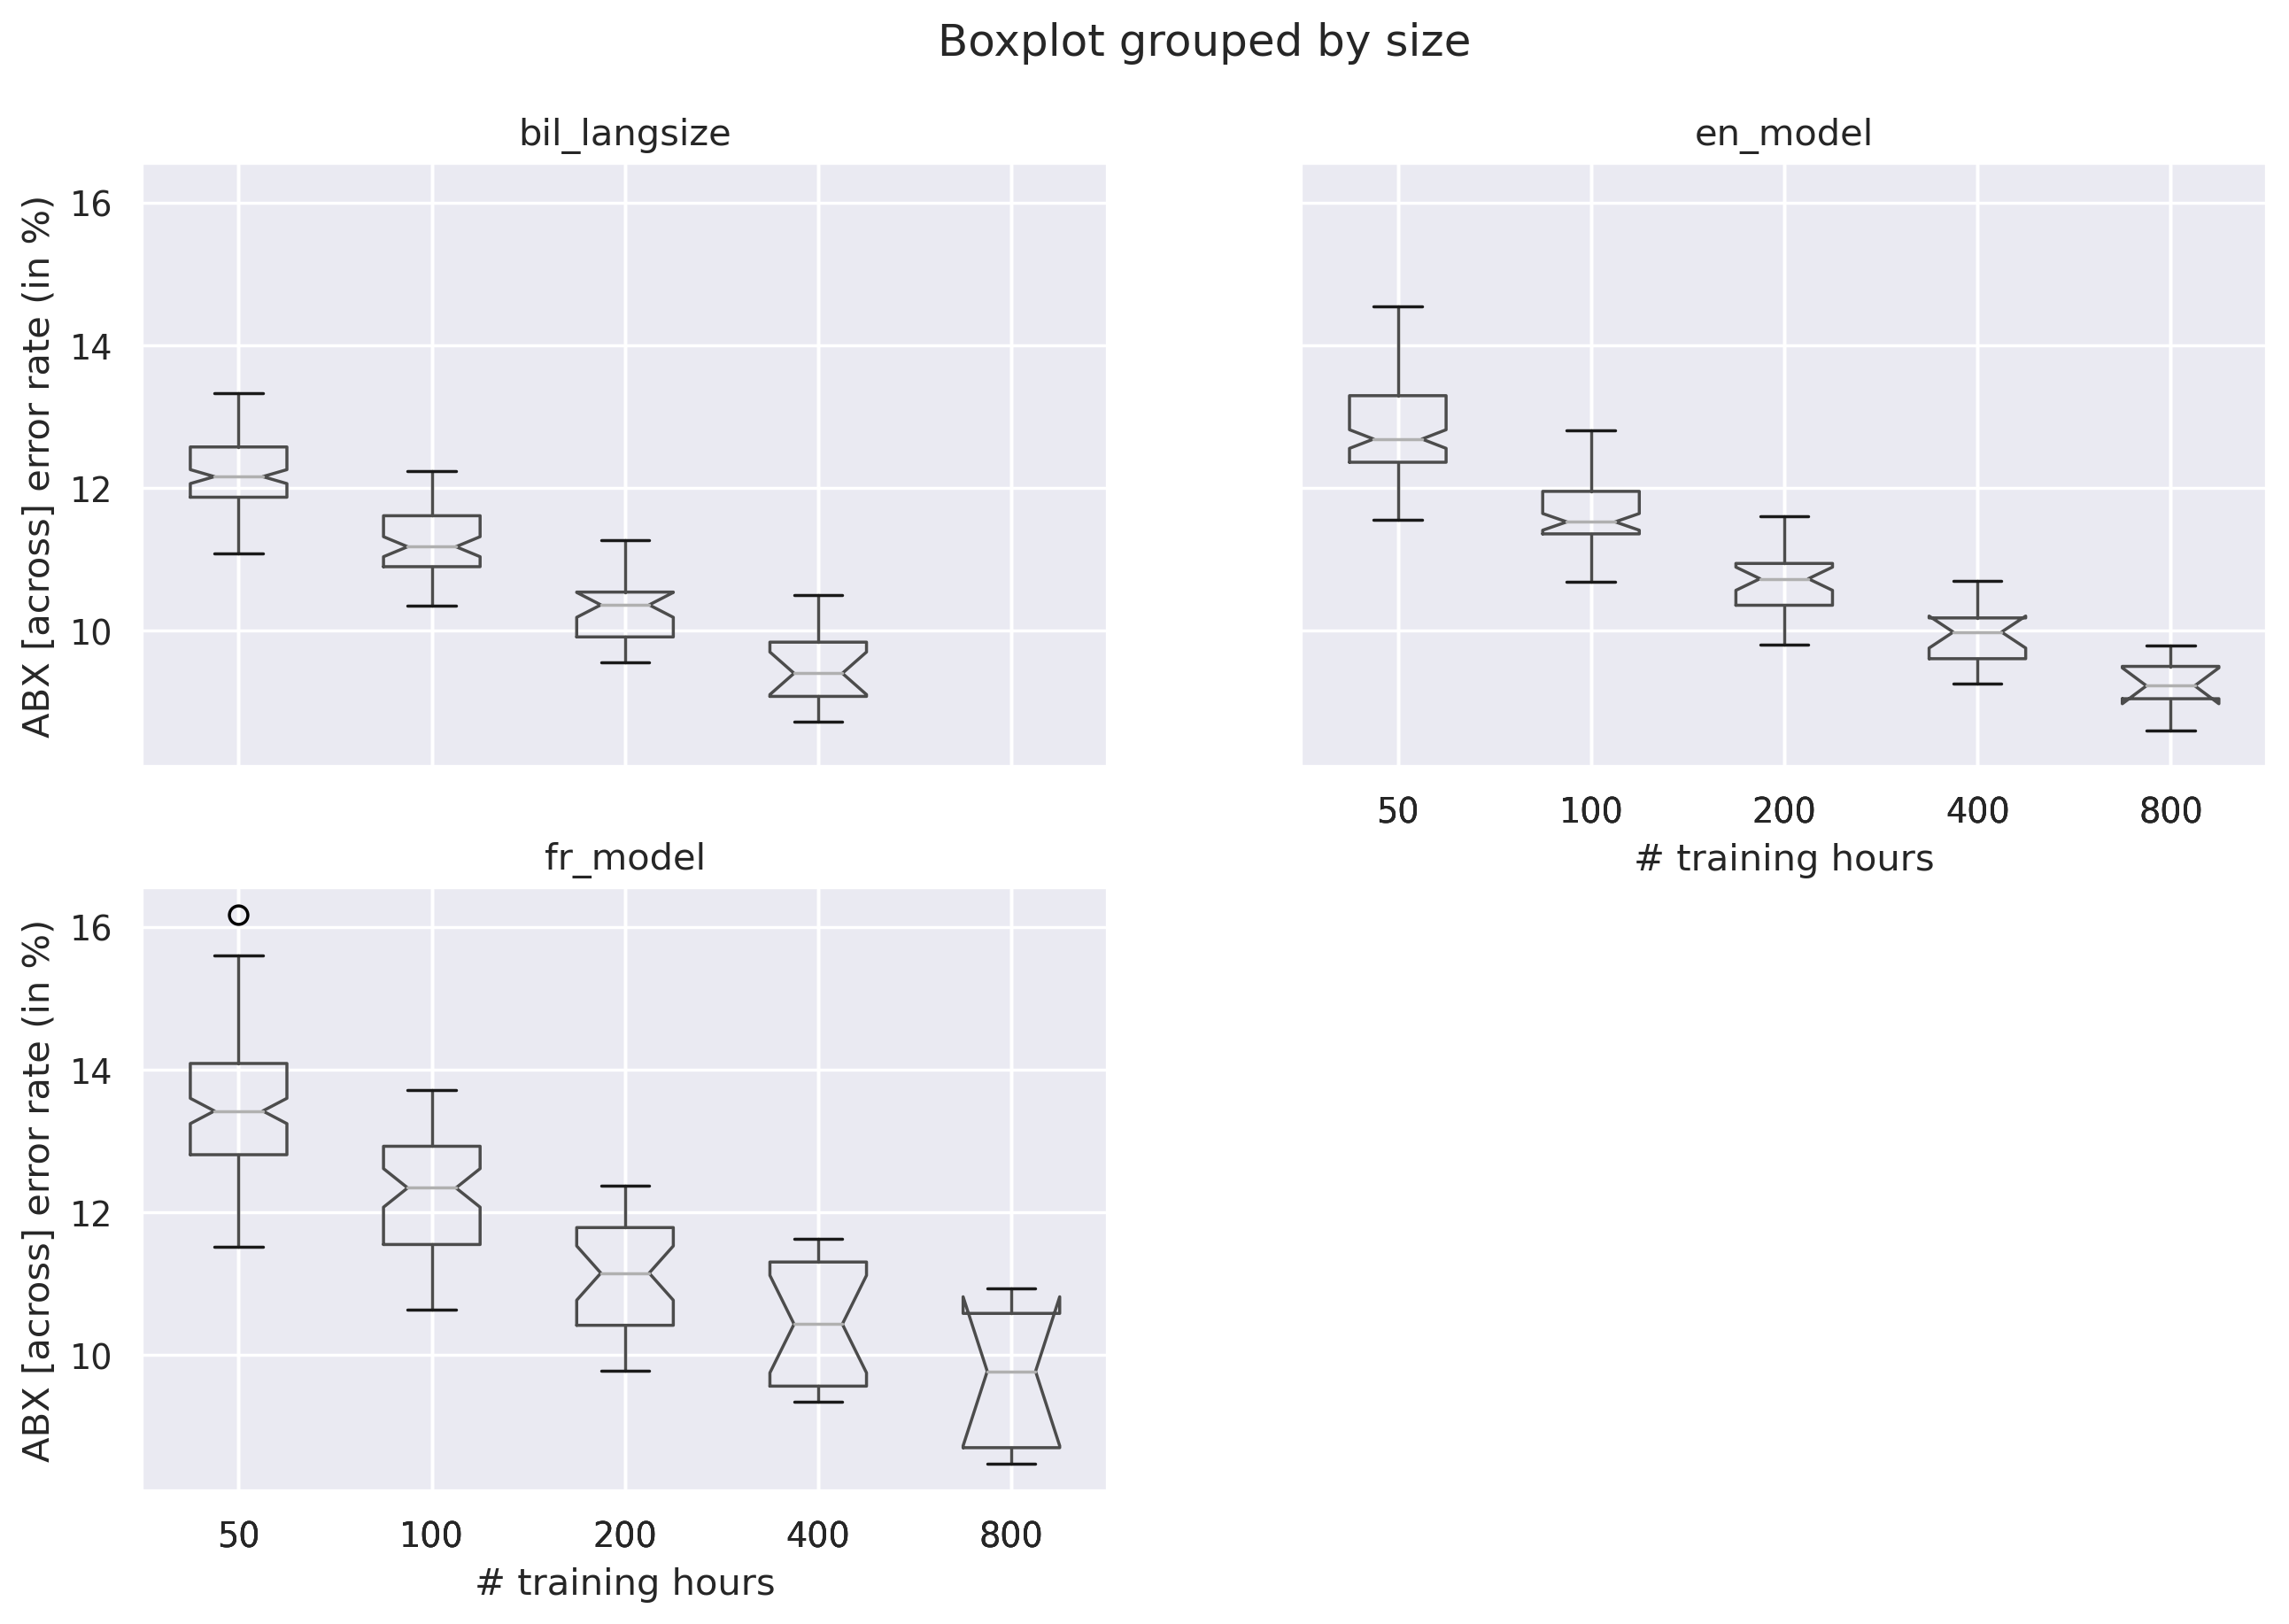

In [5]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [across] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

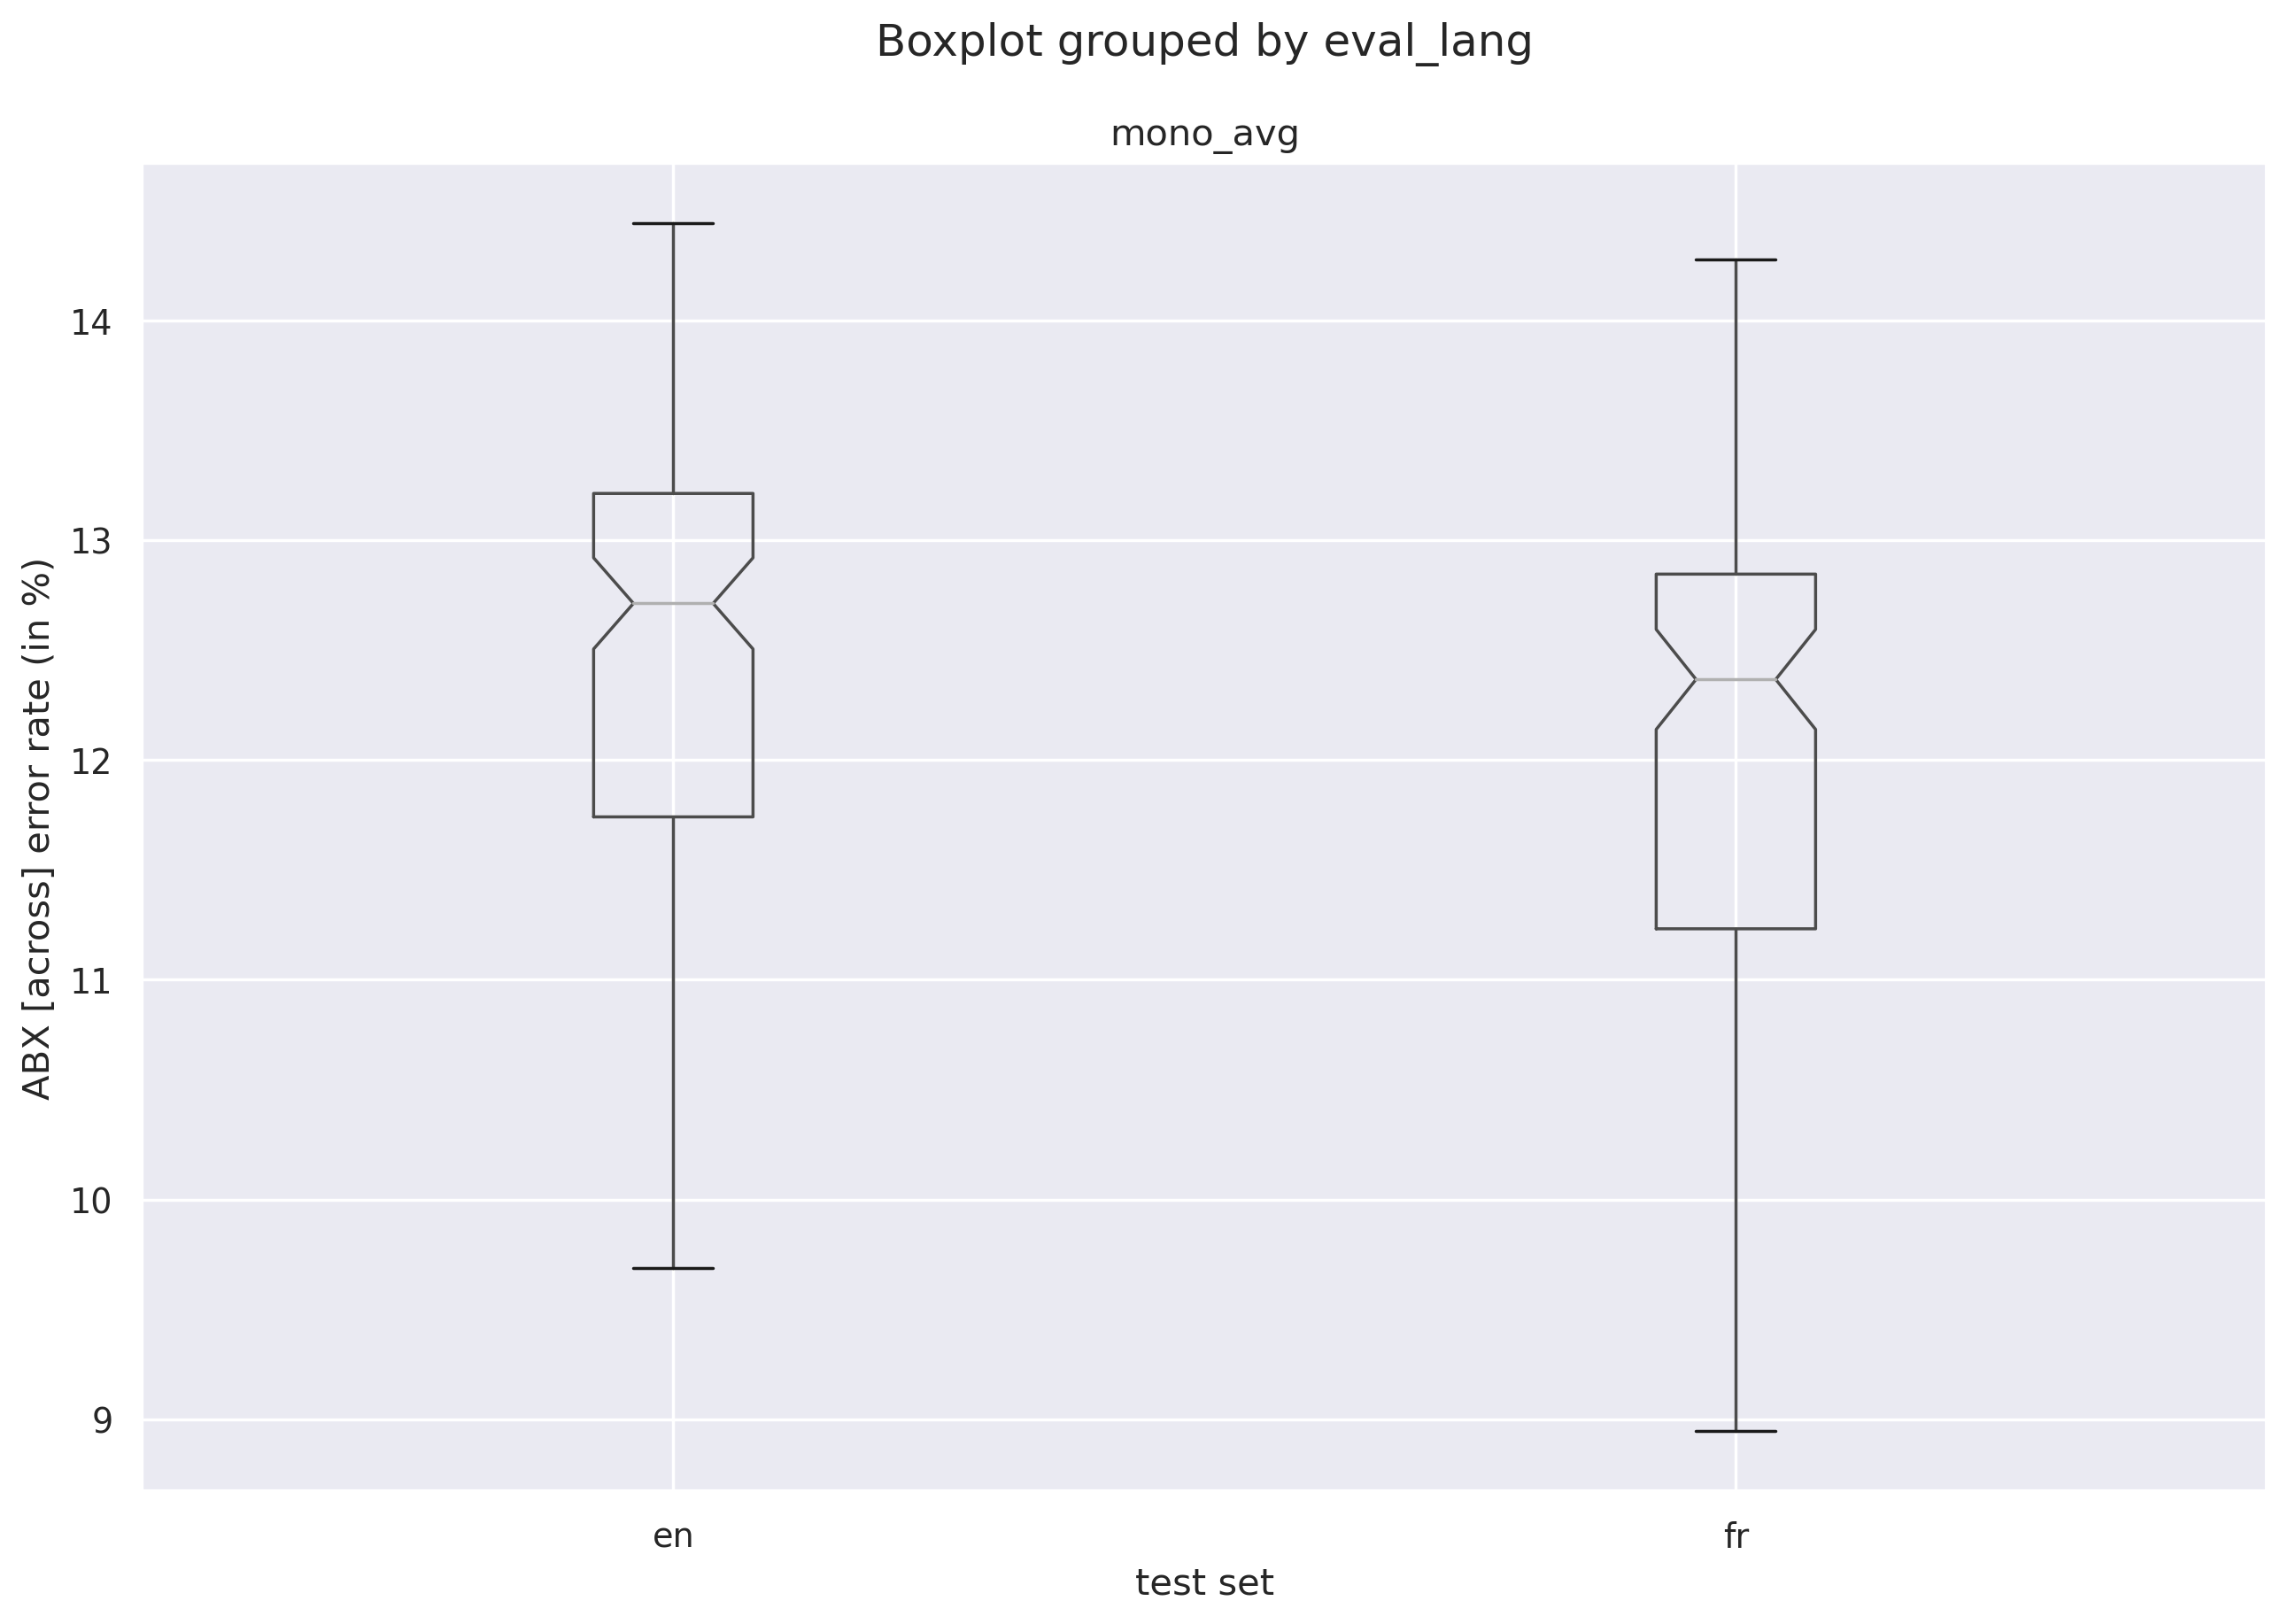

In [6]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [across] error rate (in %)')
plt.xlabel('test set')


### A2 - ABX within speakers  - original
- Test set : average of French and English
- Df : Original

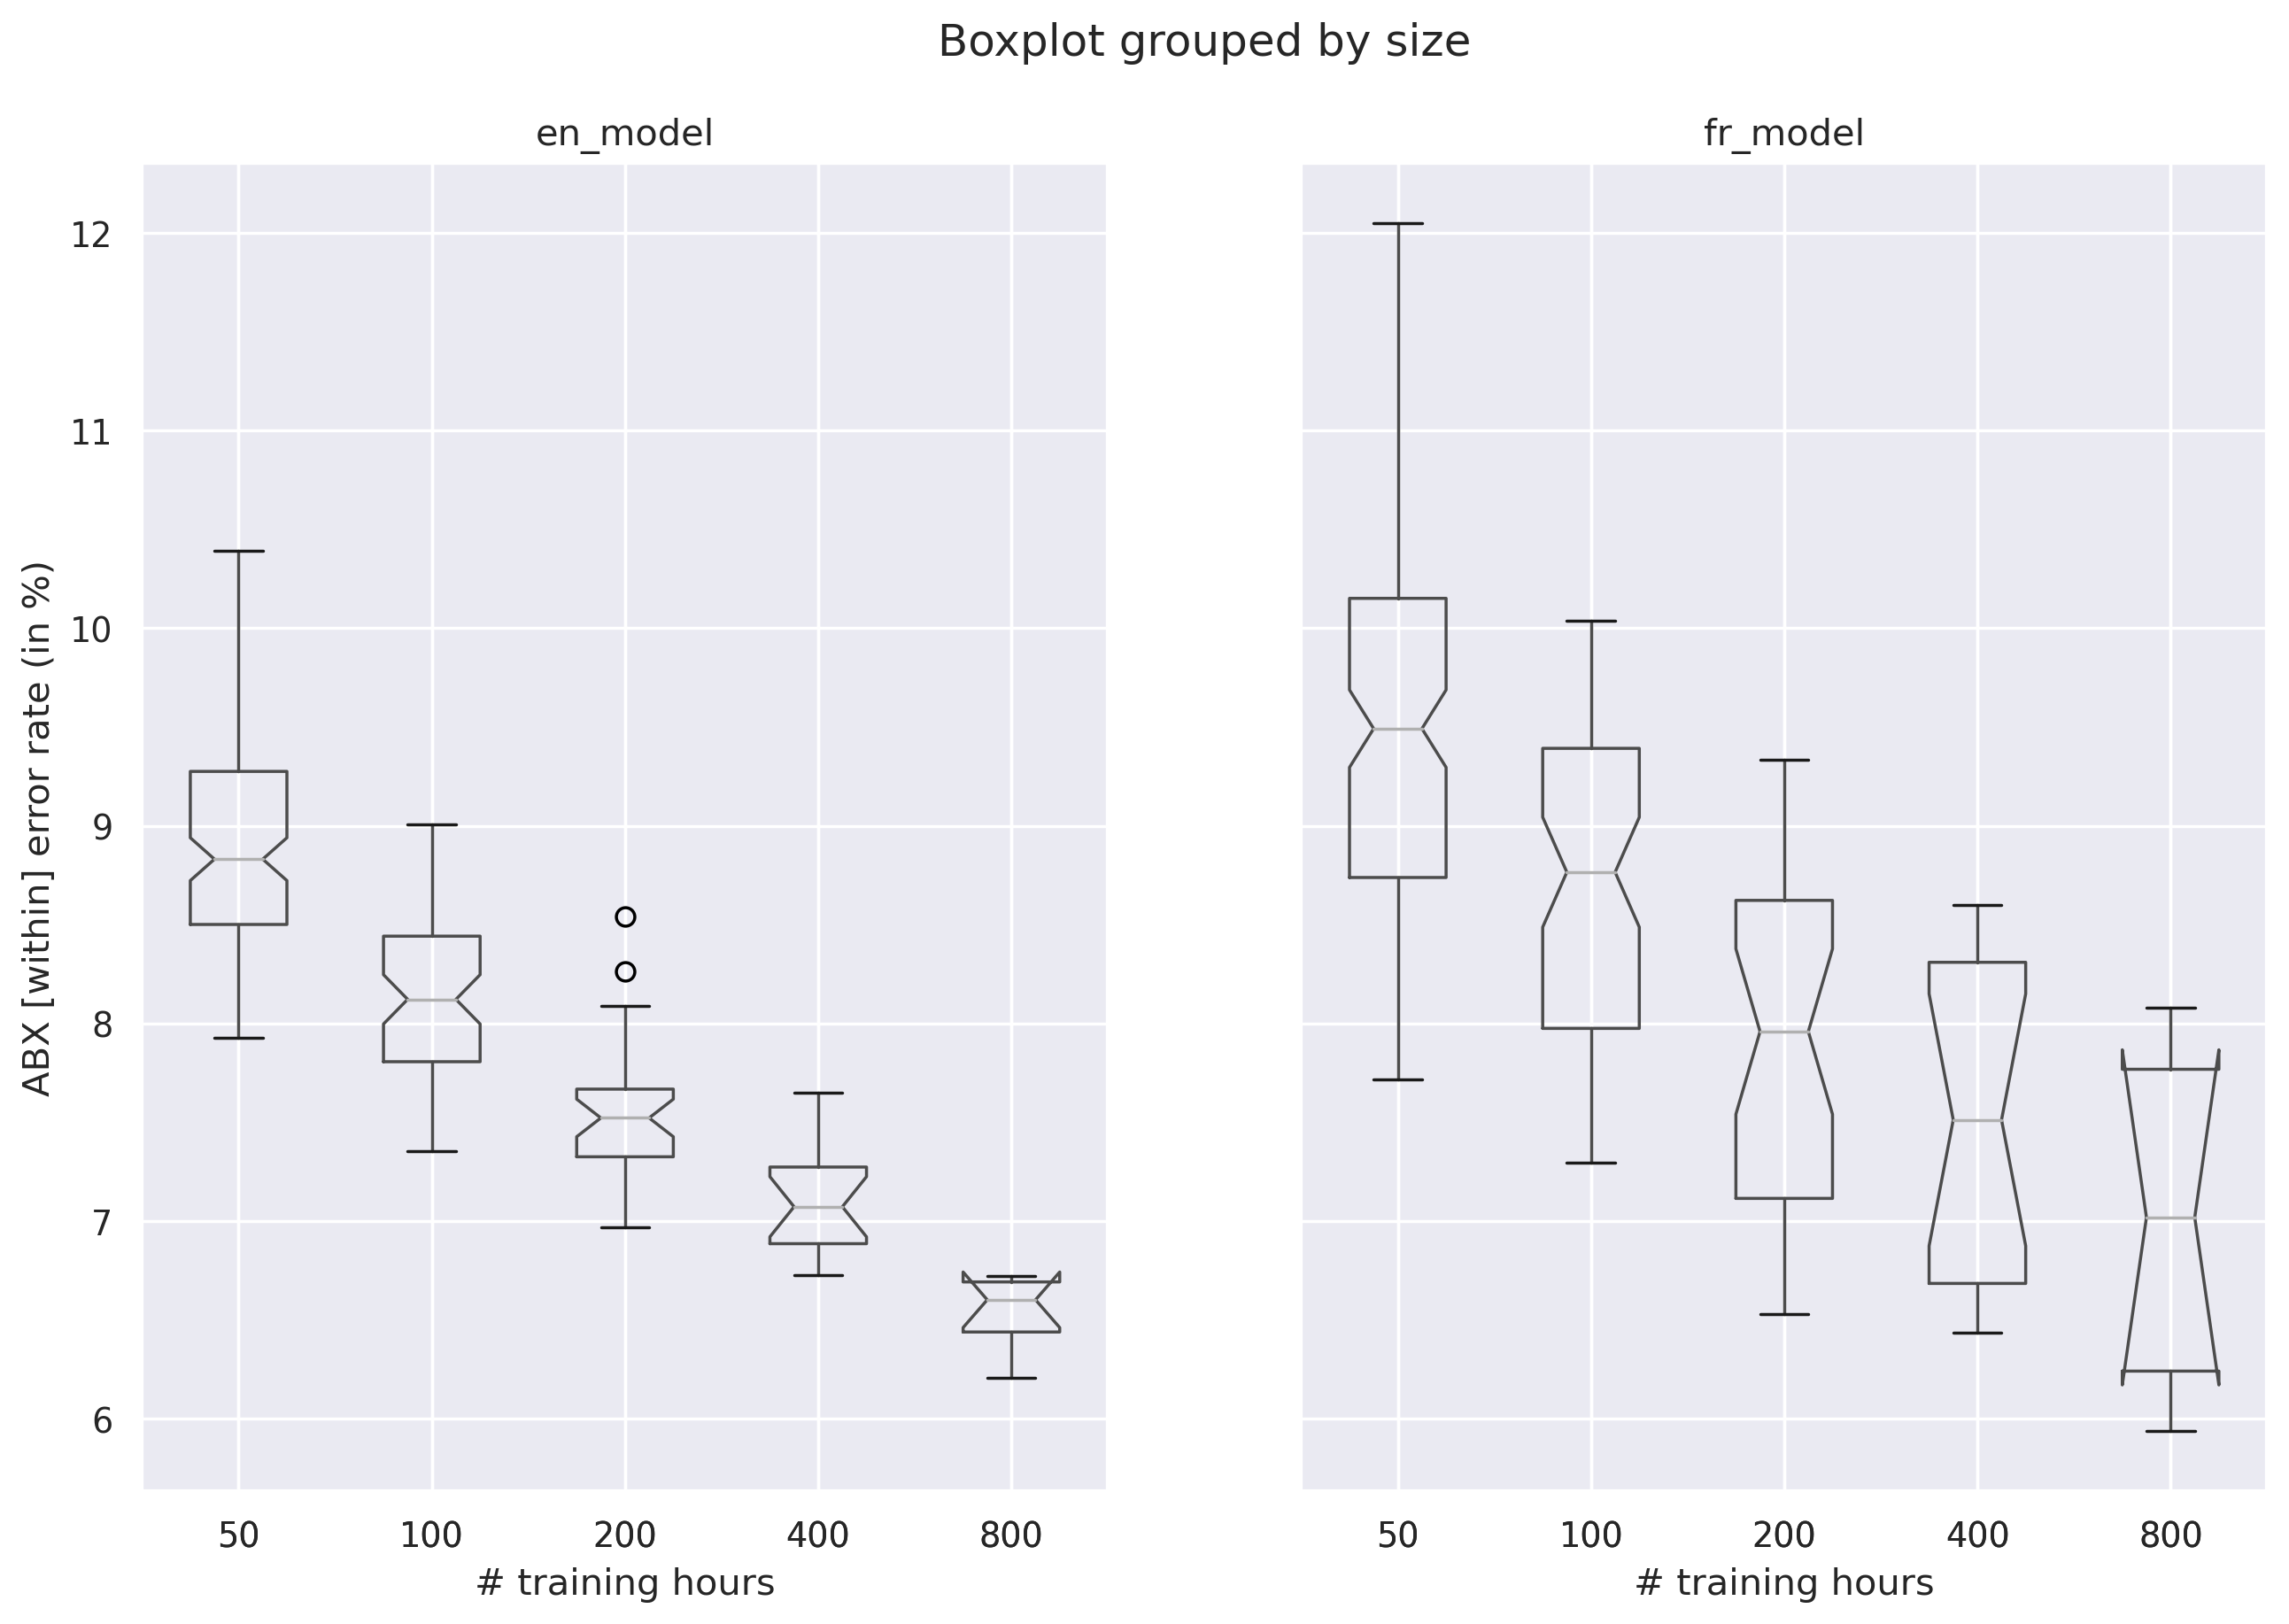

In [7]:
boxplot = df_within[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
#boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [within] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

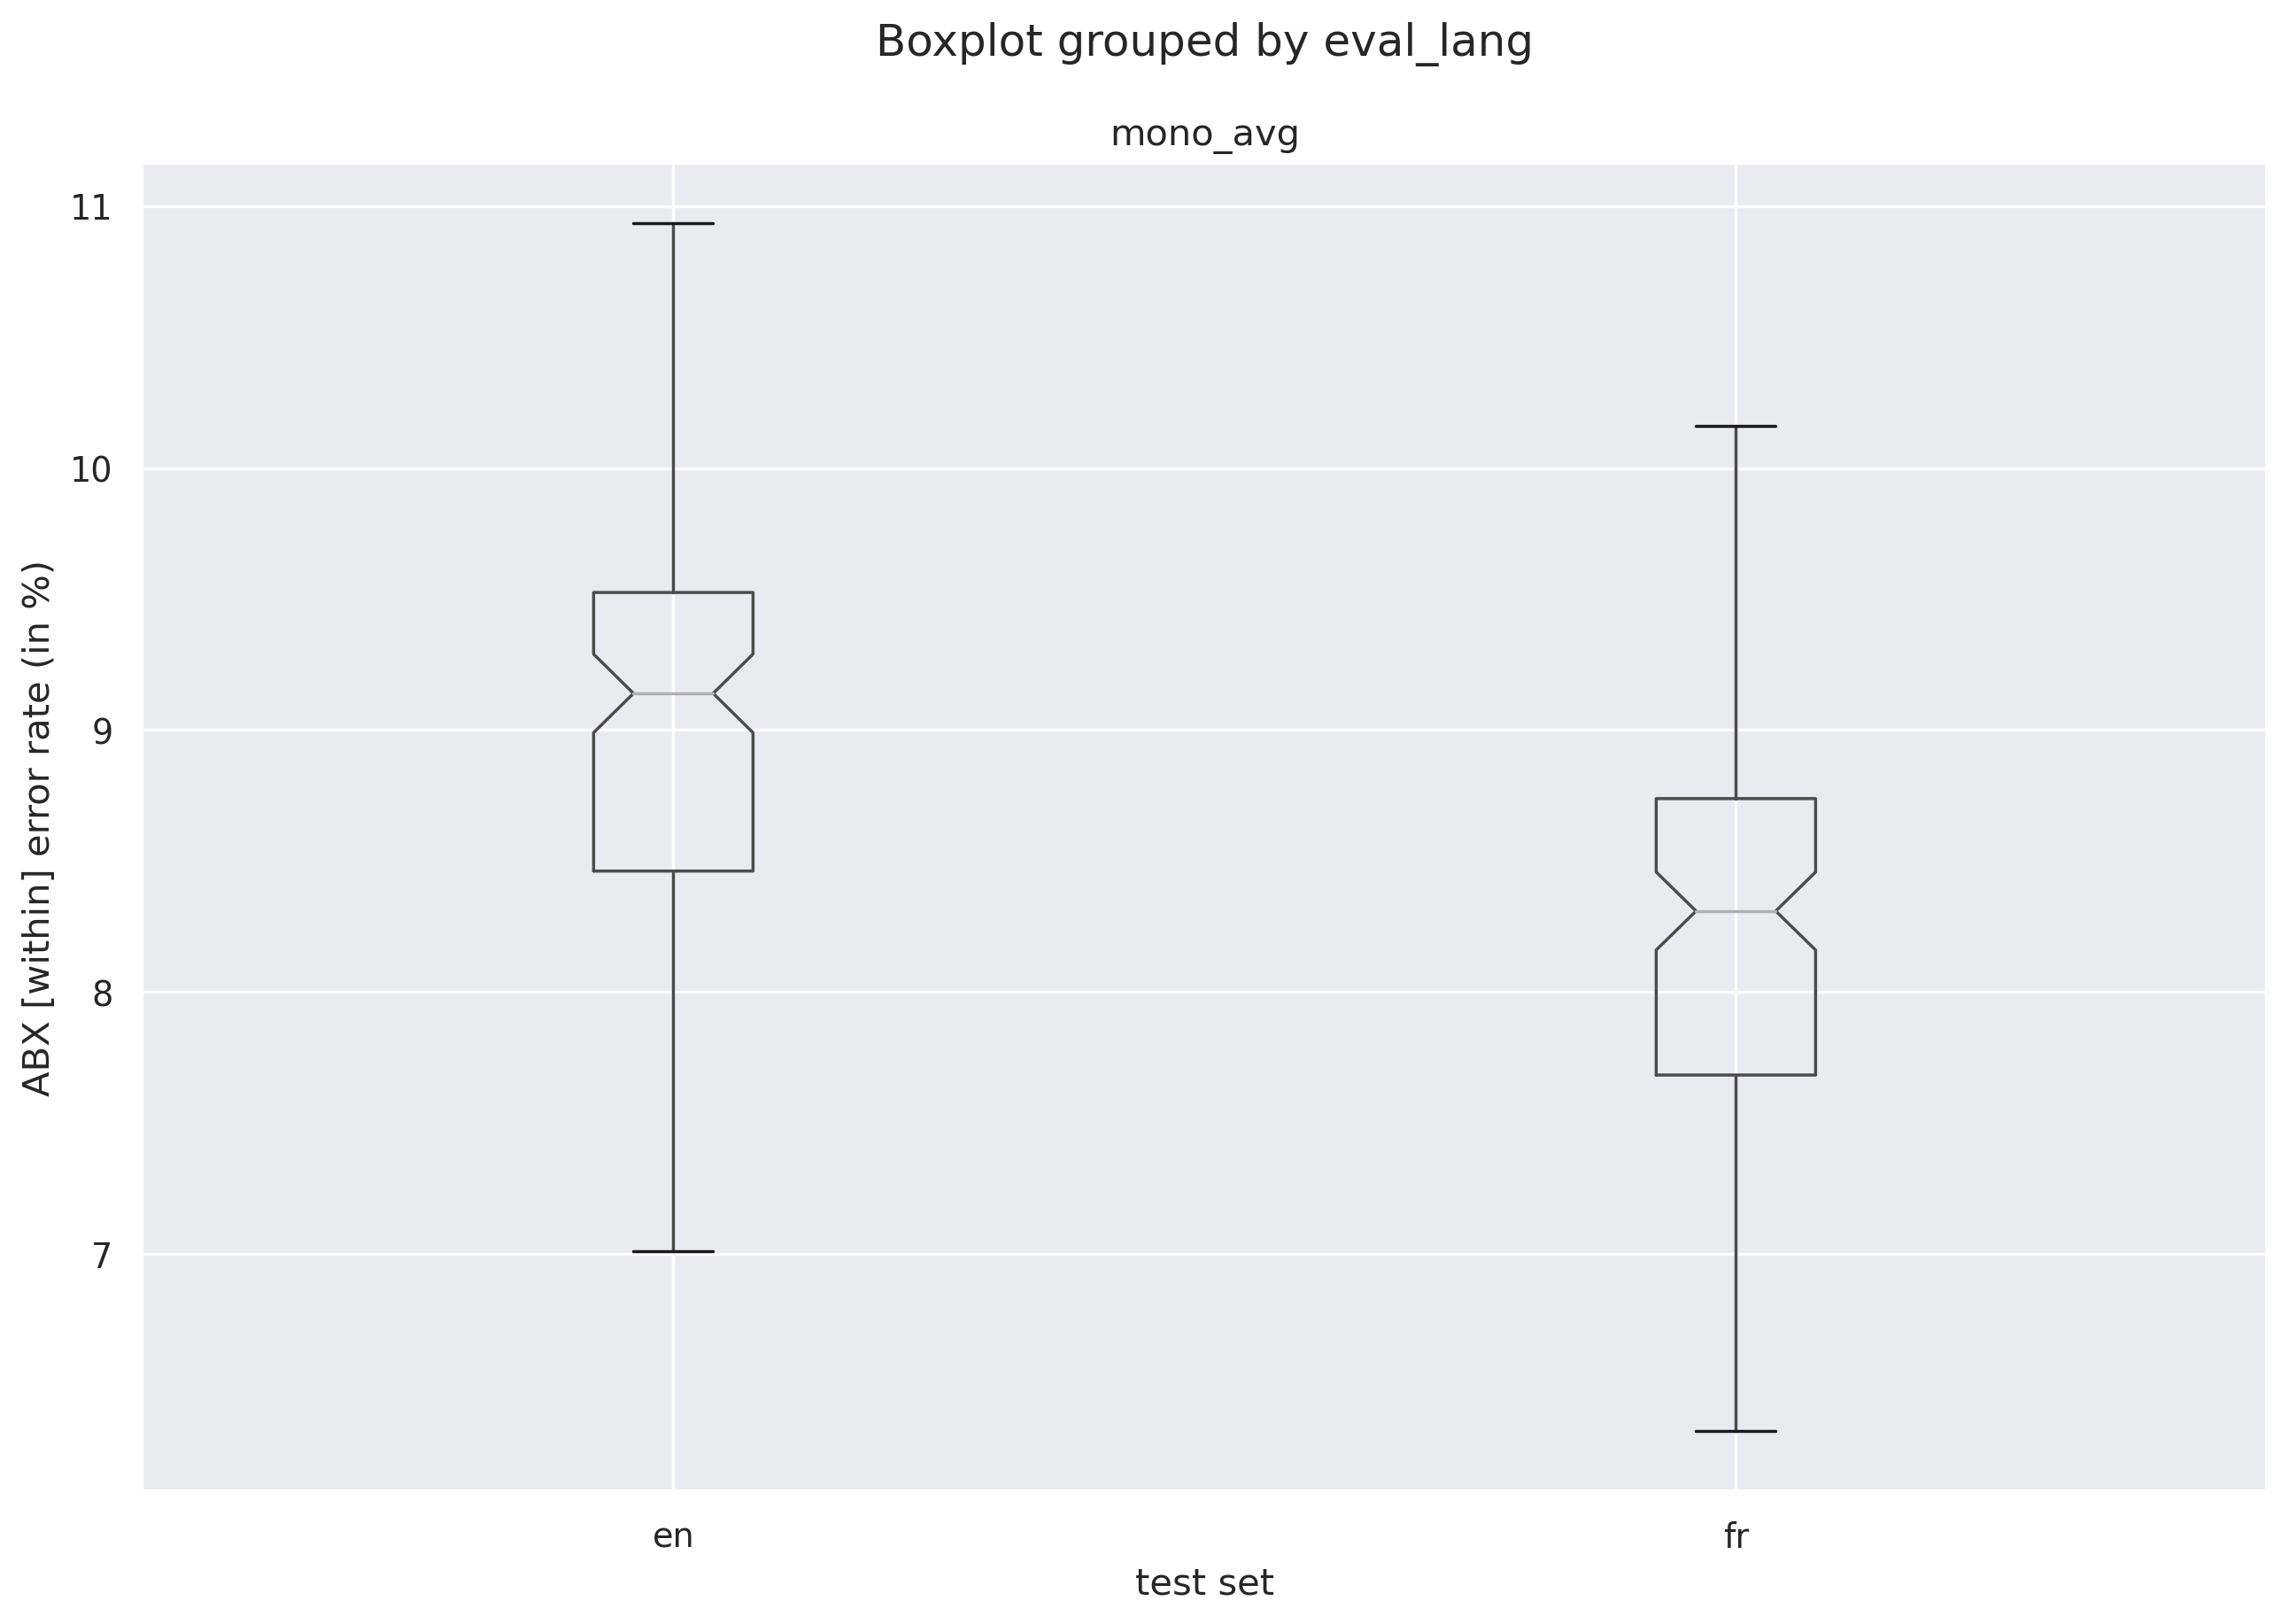

In [8]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_within[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('test set')


## C. Comparing Monolingual vs Bilingual ABX scores 



### C1. French vs English vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')

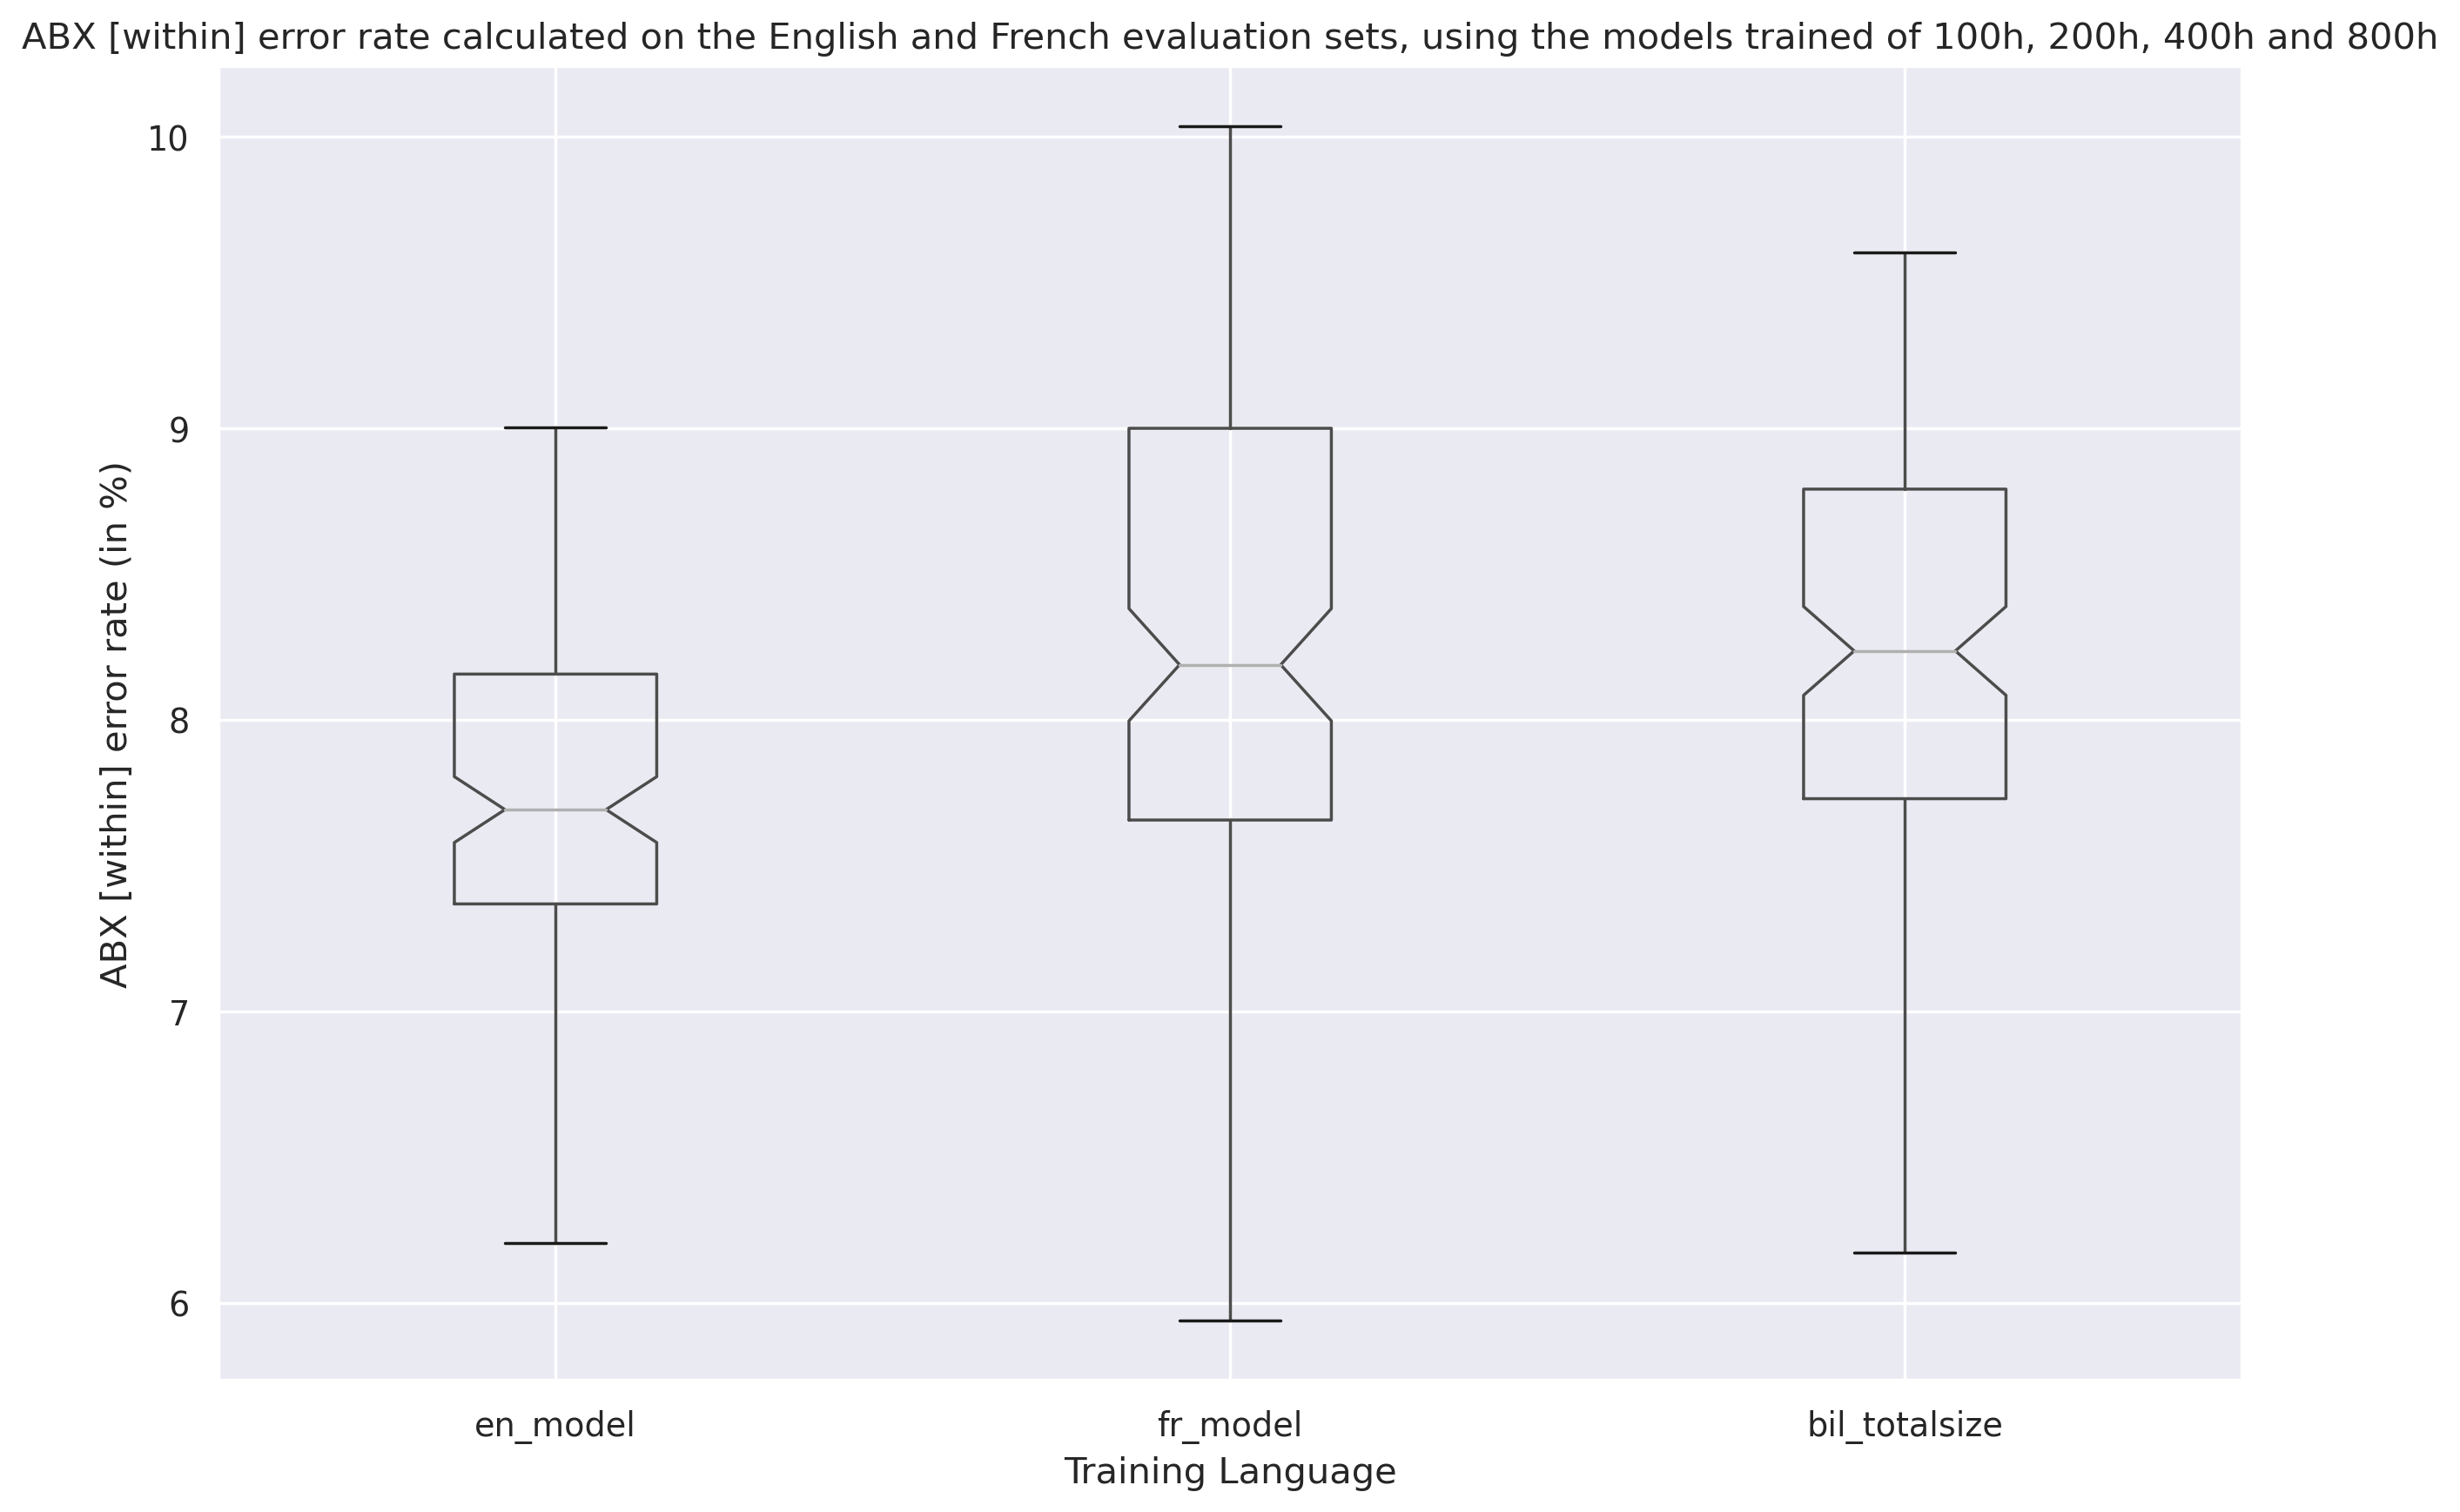

In [9]:
boxplot = df_within[['en_model', 'fr_model', 'bil_totalsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')



### C2. Monolingual vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')

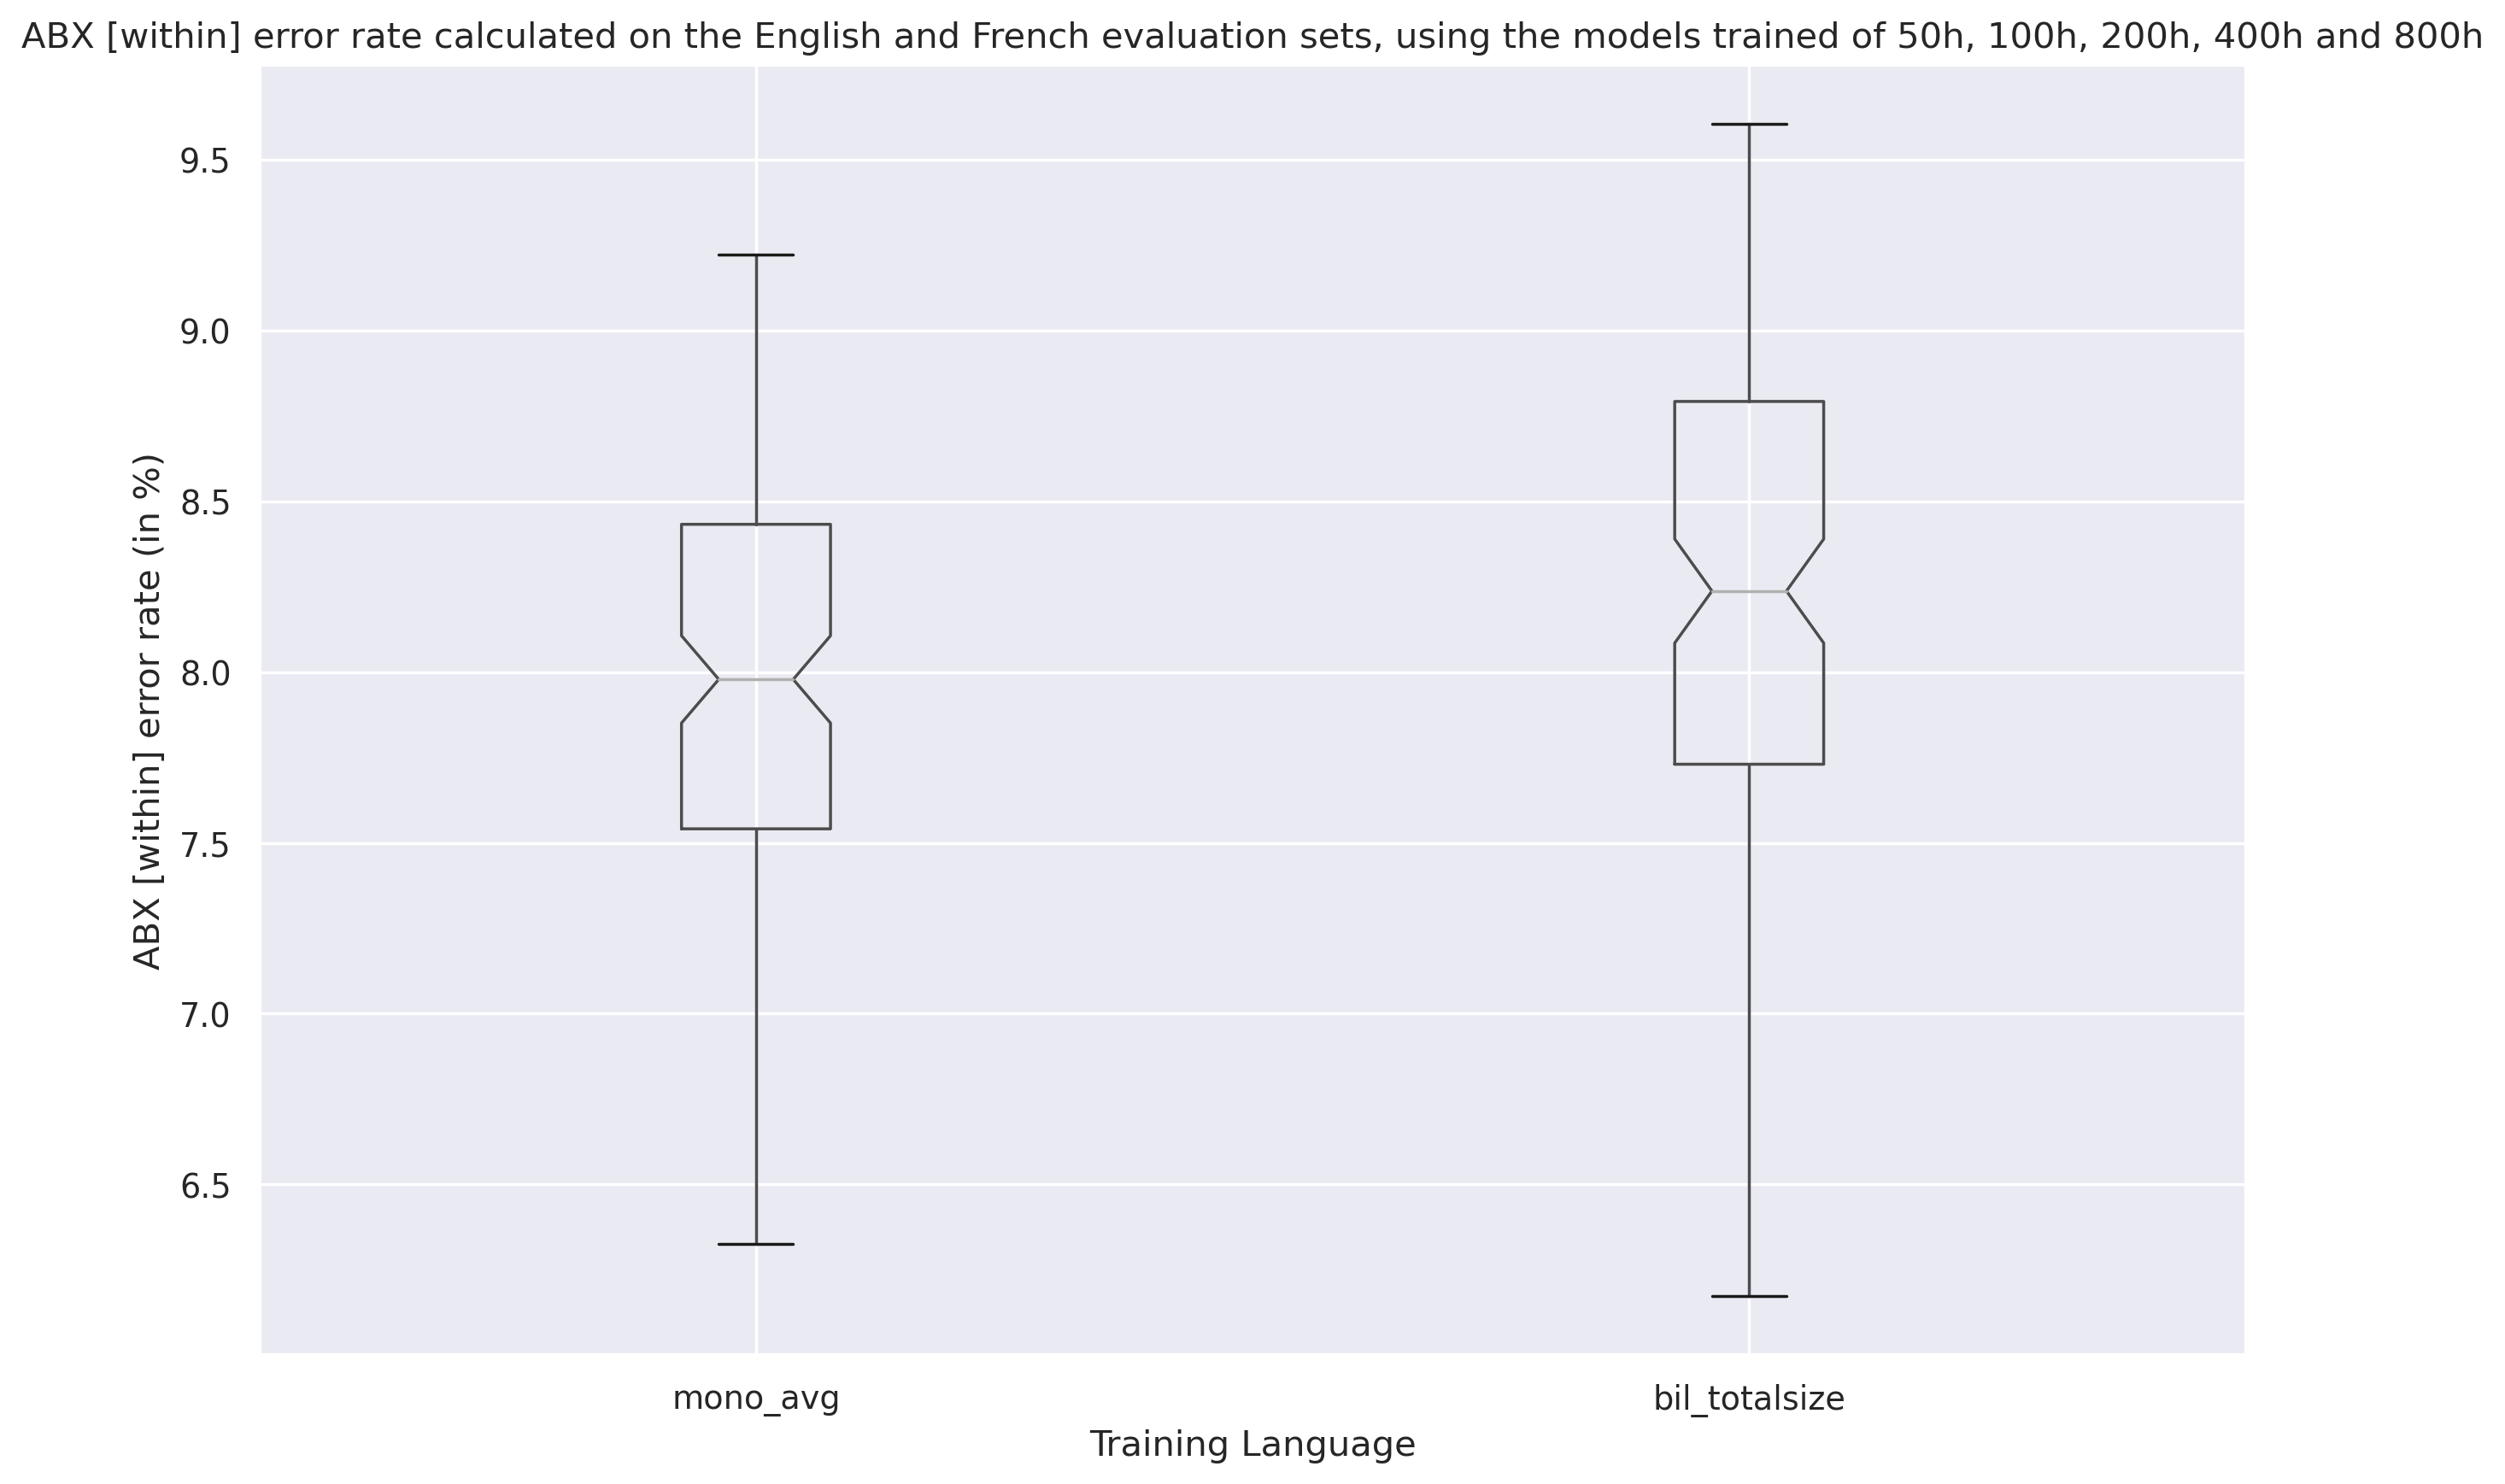

In [10]:
boxplot = df_within[['mono_avg', 'bil_totalsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')



### C3. Monolingual vs Bilingual LangSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the largest dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')

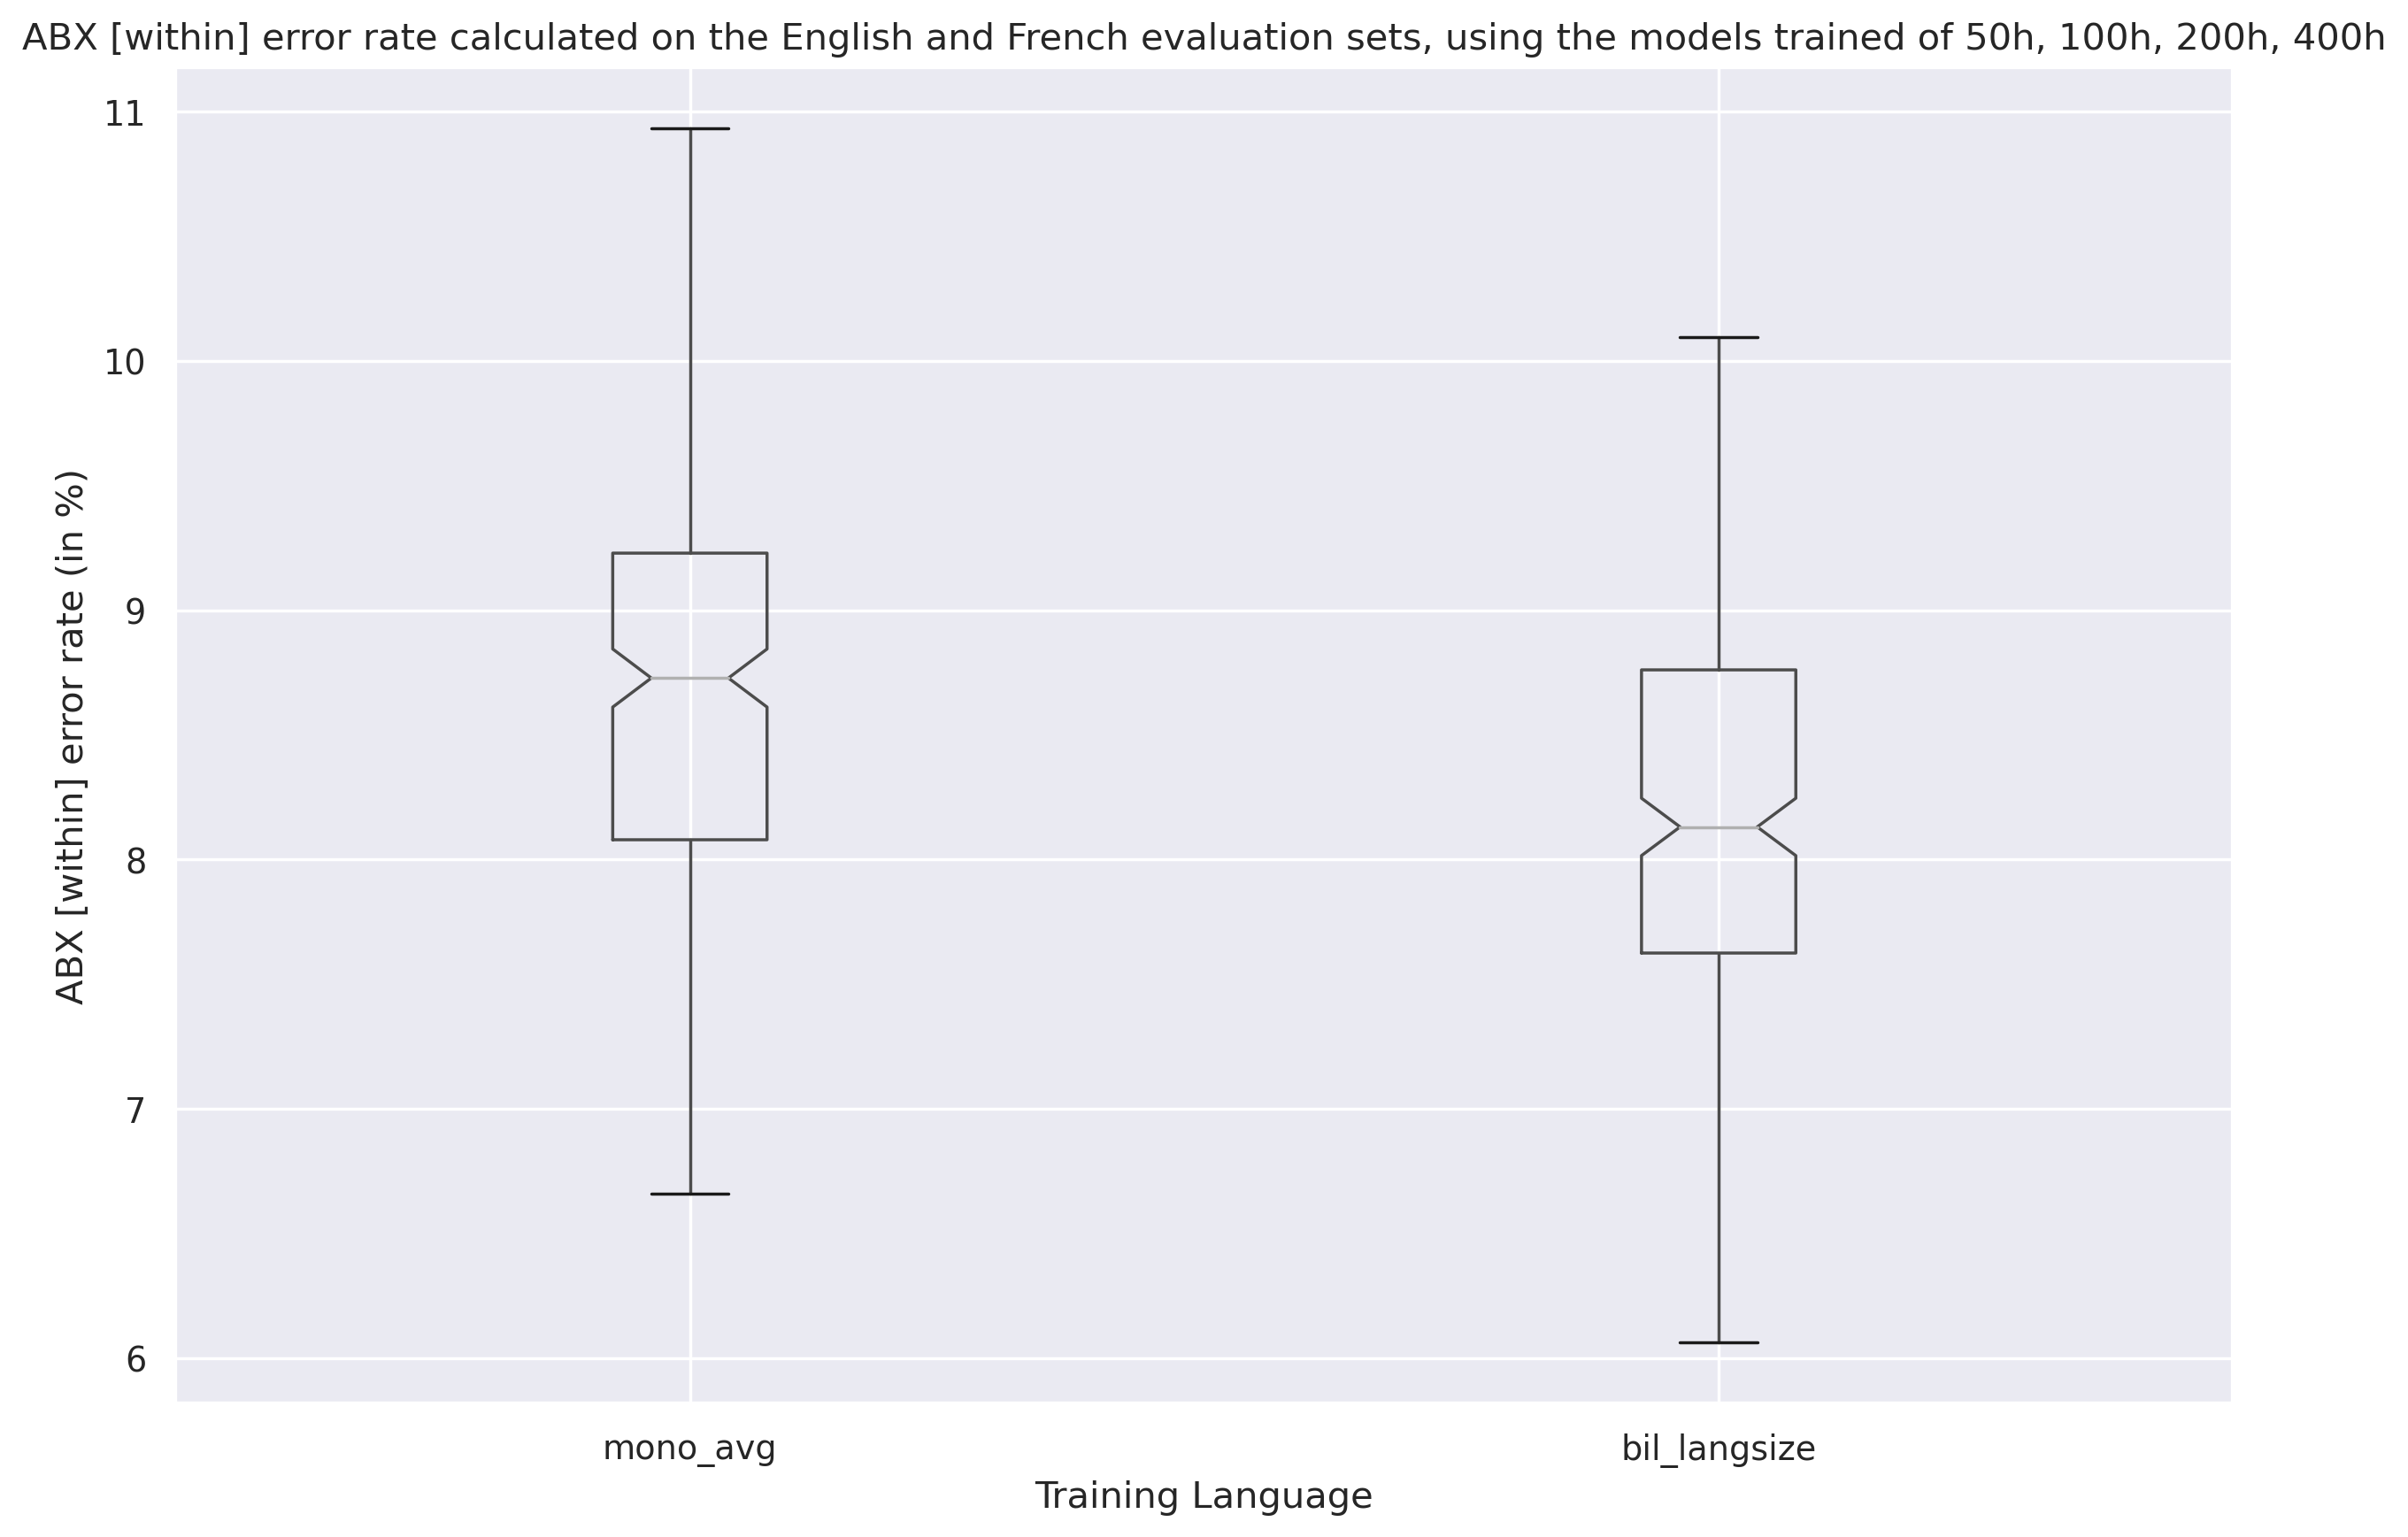

In [11]:
boxplot = df_within[['mono_avg', 'bil_langsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')



## D. Developmental graphs

In [12]:
style_dict =  {'same': 'go-', 'different': 'ro-', 'bil_totalsize': 'bo:', 'bil_langsize':'co:', 'en_model' : 'go--', 'fr_model' : 'ro--', 'mono_avg':'wo-.'}


### D1. Developmental [within] ABX  on both test sets (original)

(6.0, 14.0)

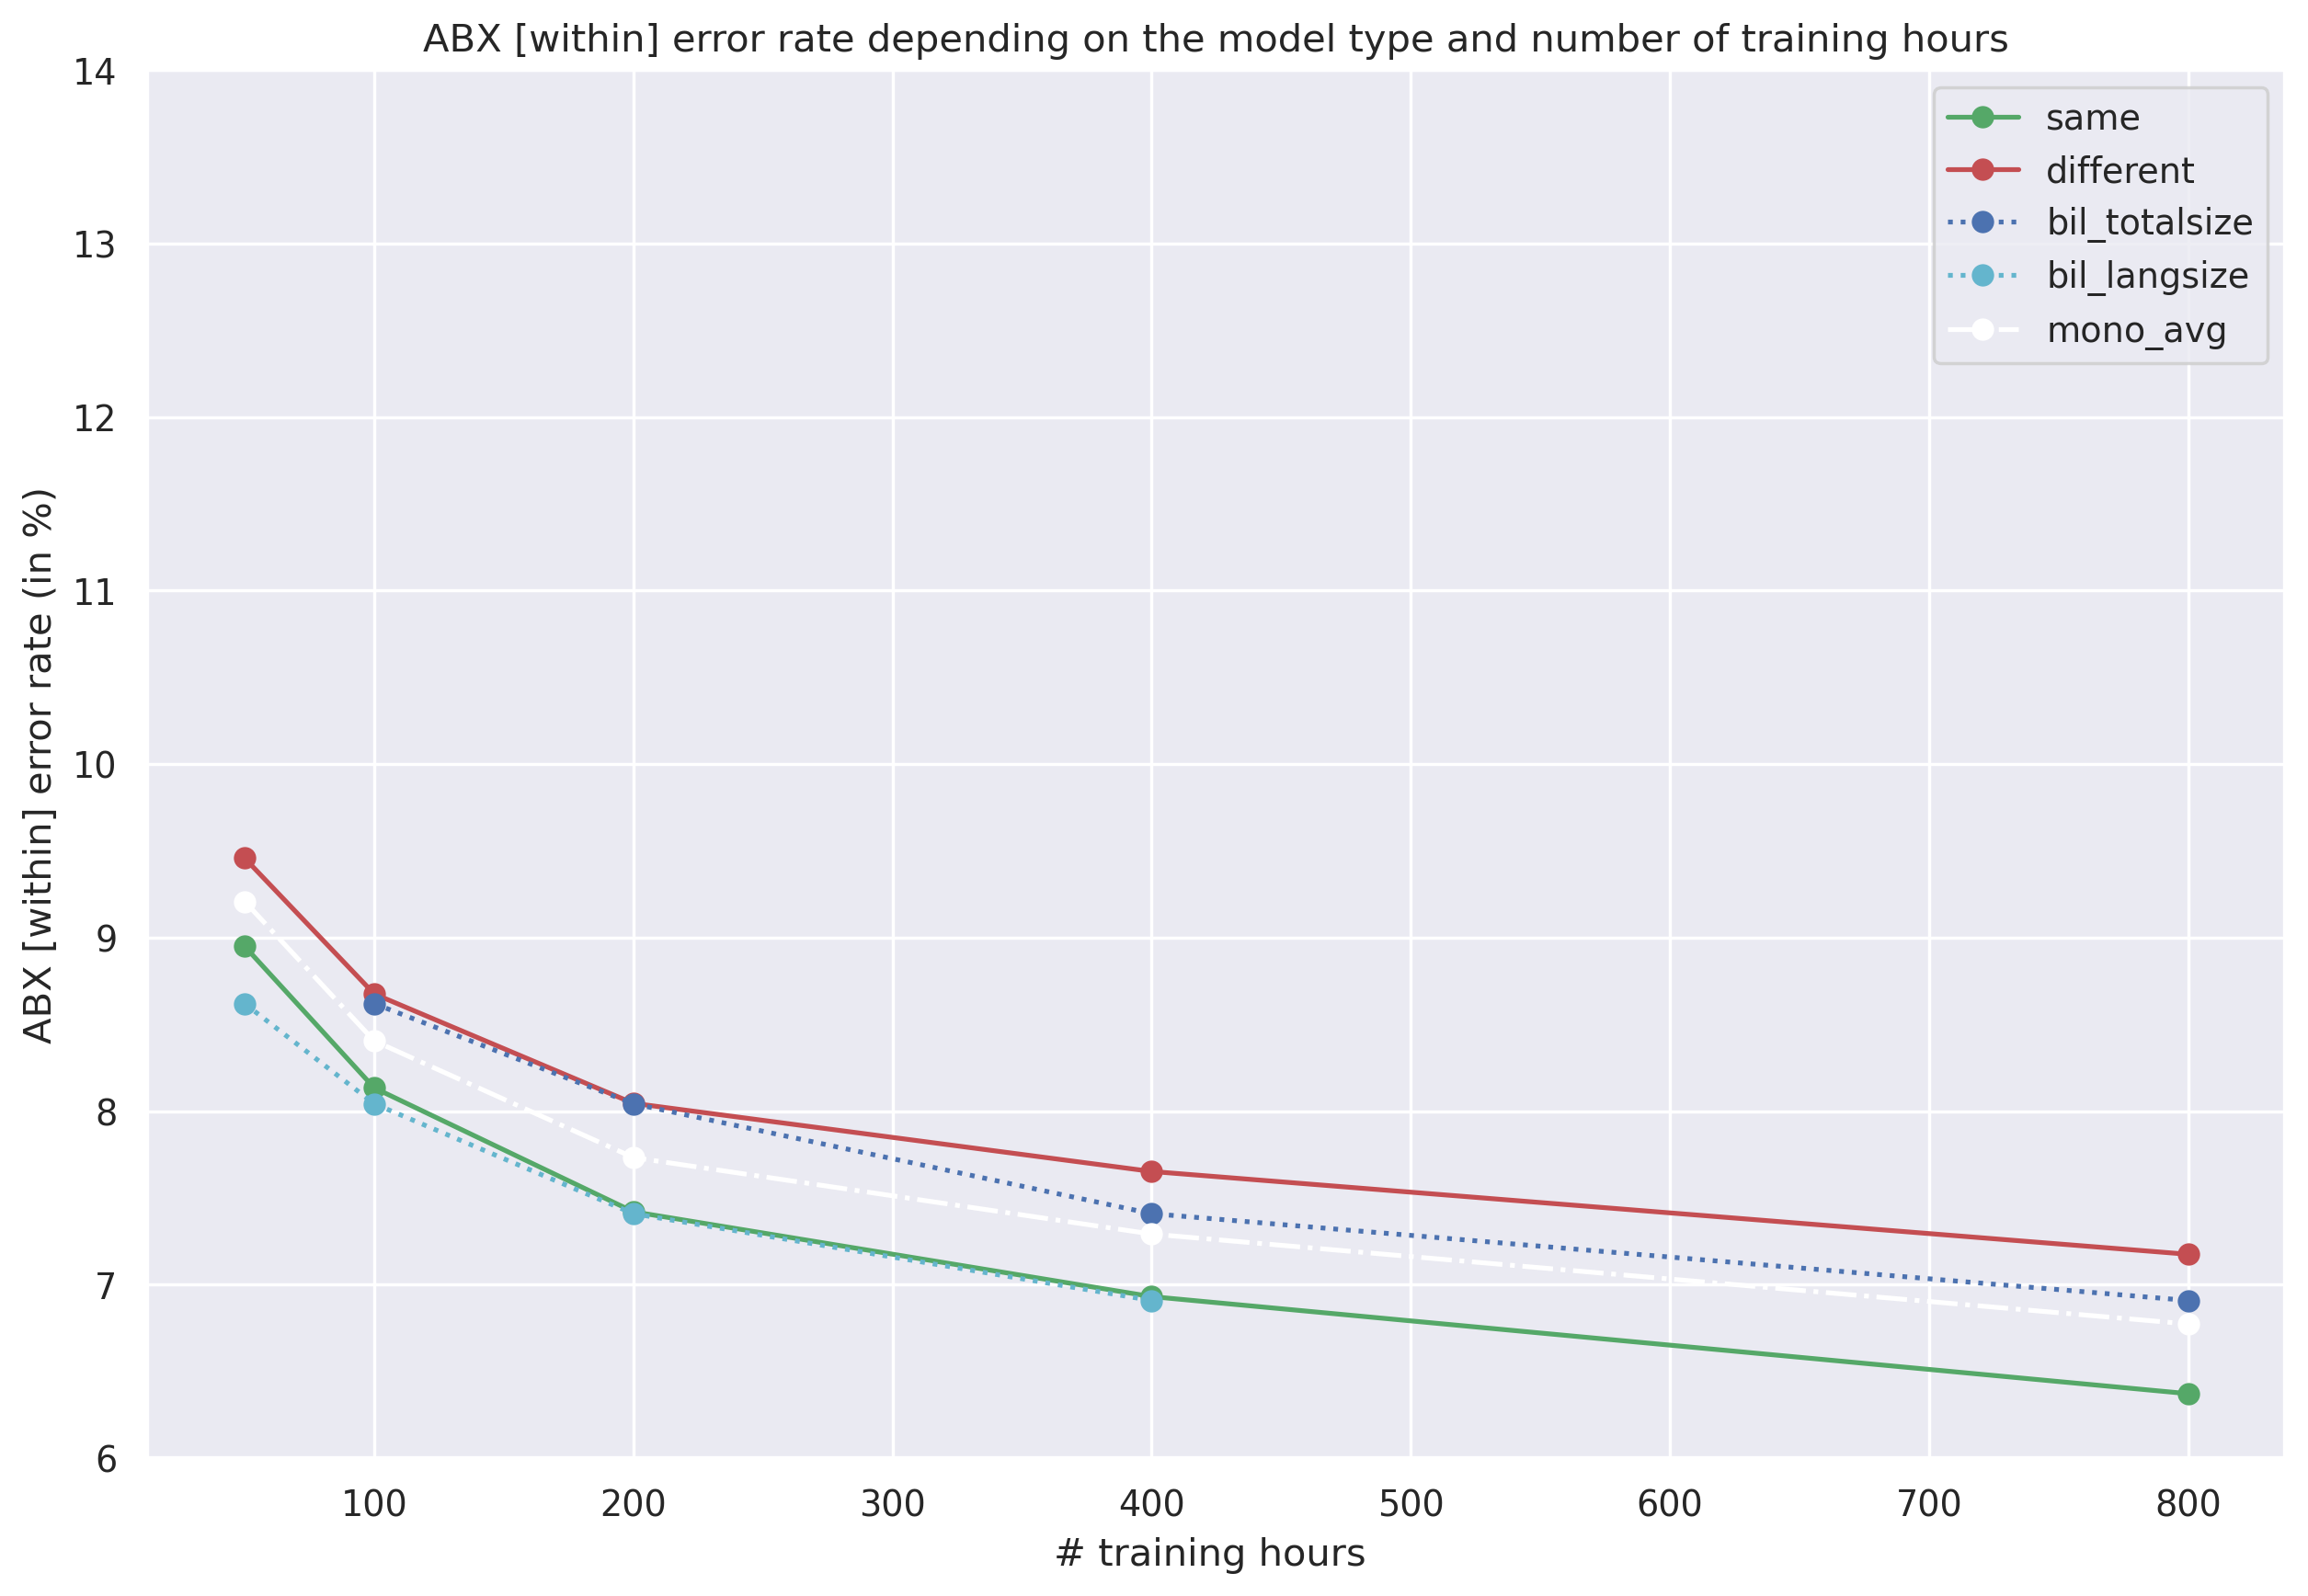

In [13]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
#df_within_size[['same', 'different']].plot(style = style_dict)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours")
plt.ylim([6,14])

(6, 14)

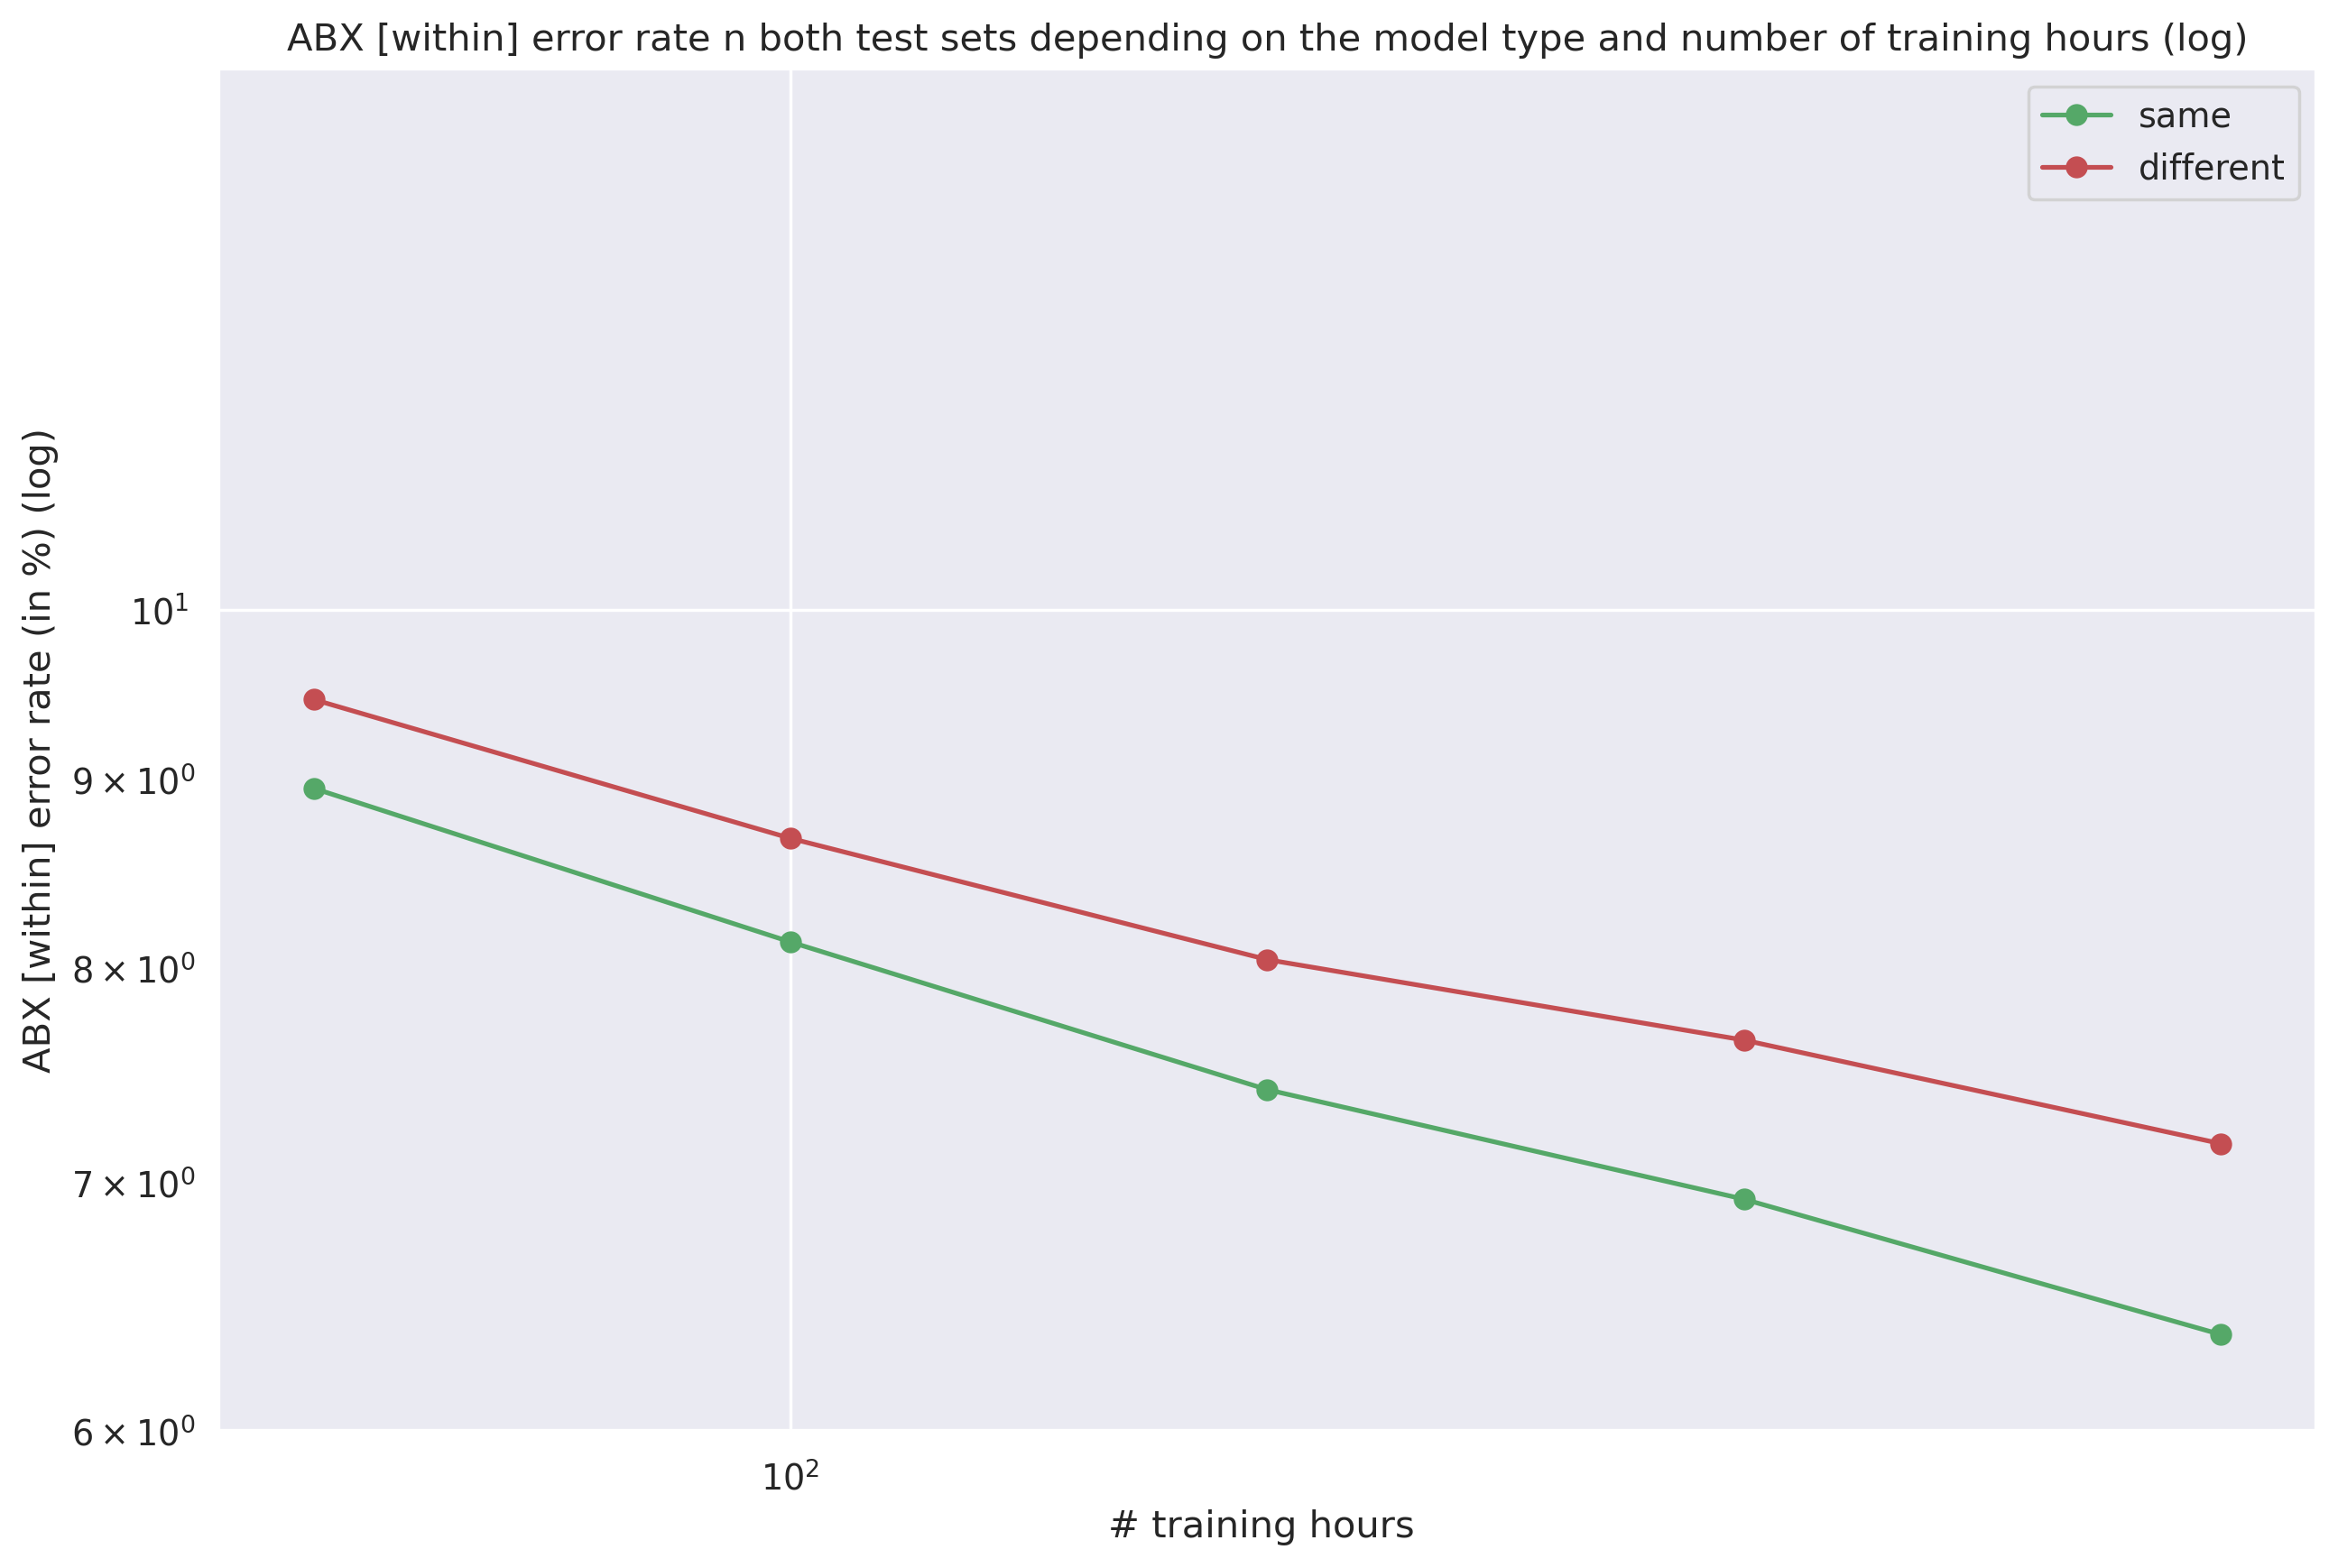

In [46]:
#df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
df_within_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %) (log)")
plt.title("ABX [within] error rate n both test sets depending on the model type and number of training hours (log)")
plt.ylim([6,14])

(6, 14)

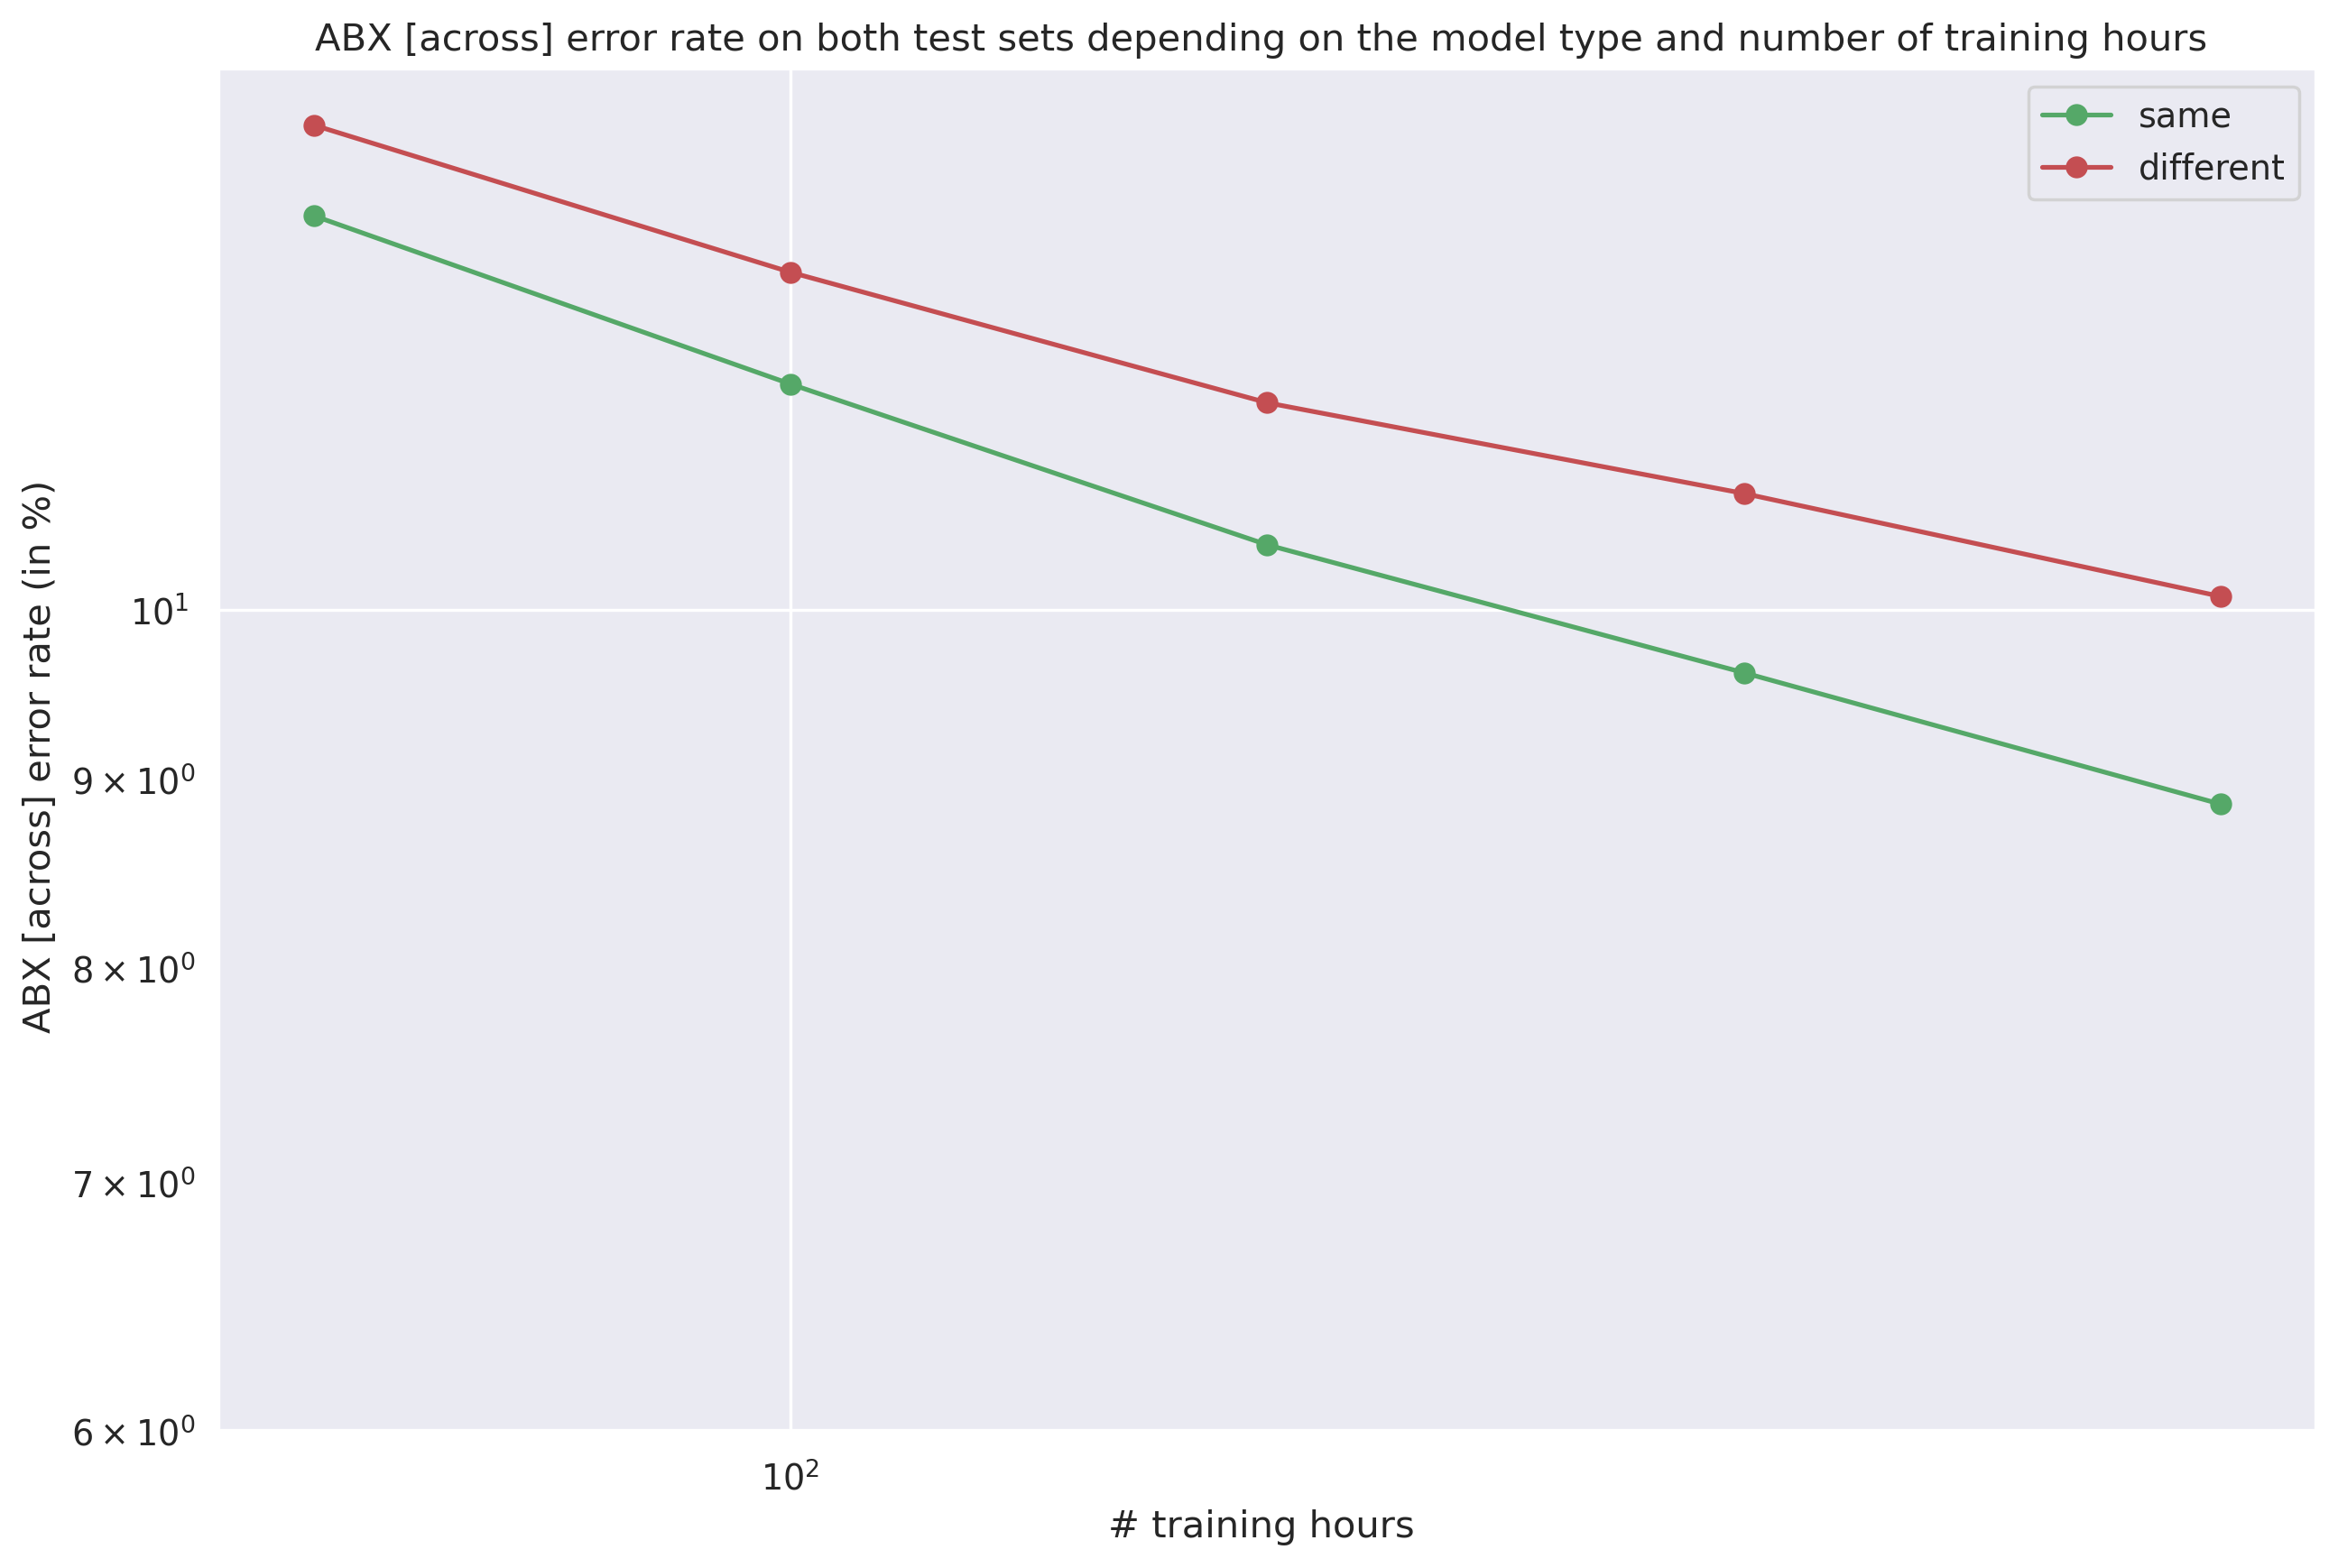

In [47]:
#df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) ")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours ")
plt.ylim([6,14])

(6, 14)

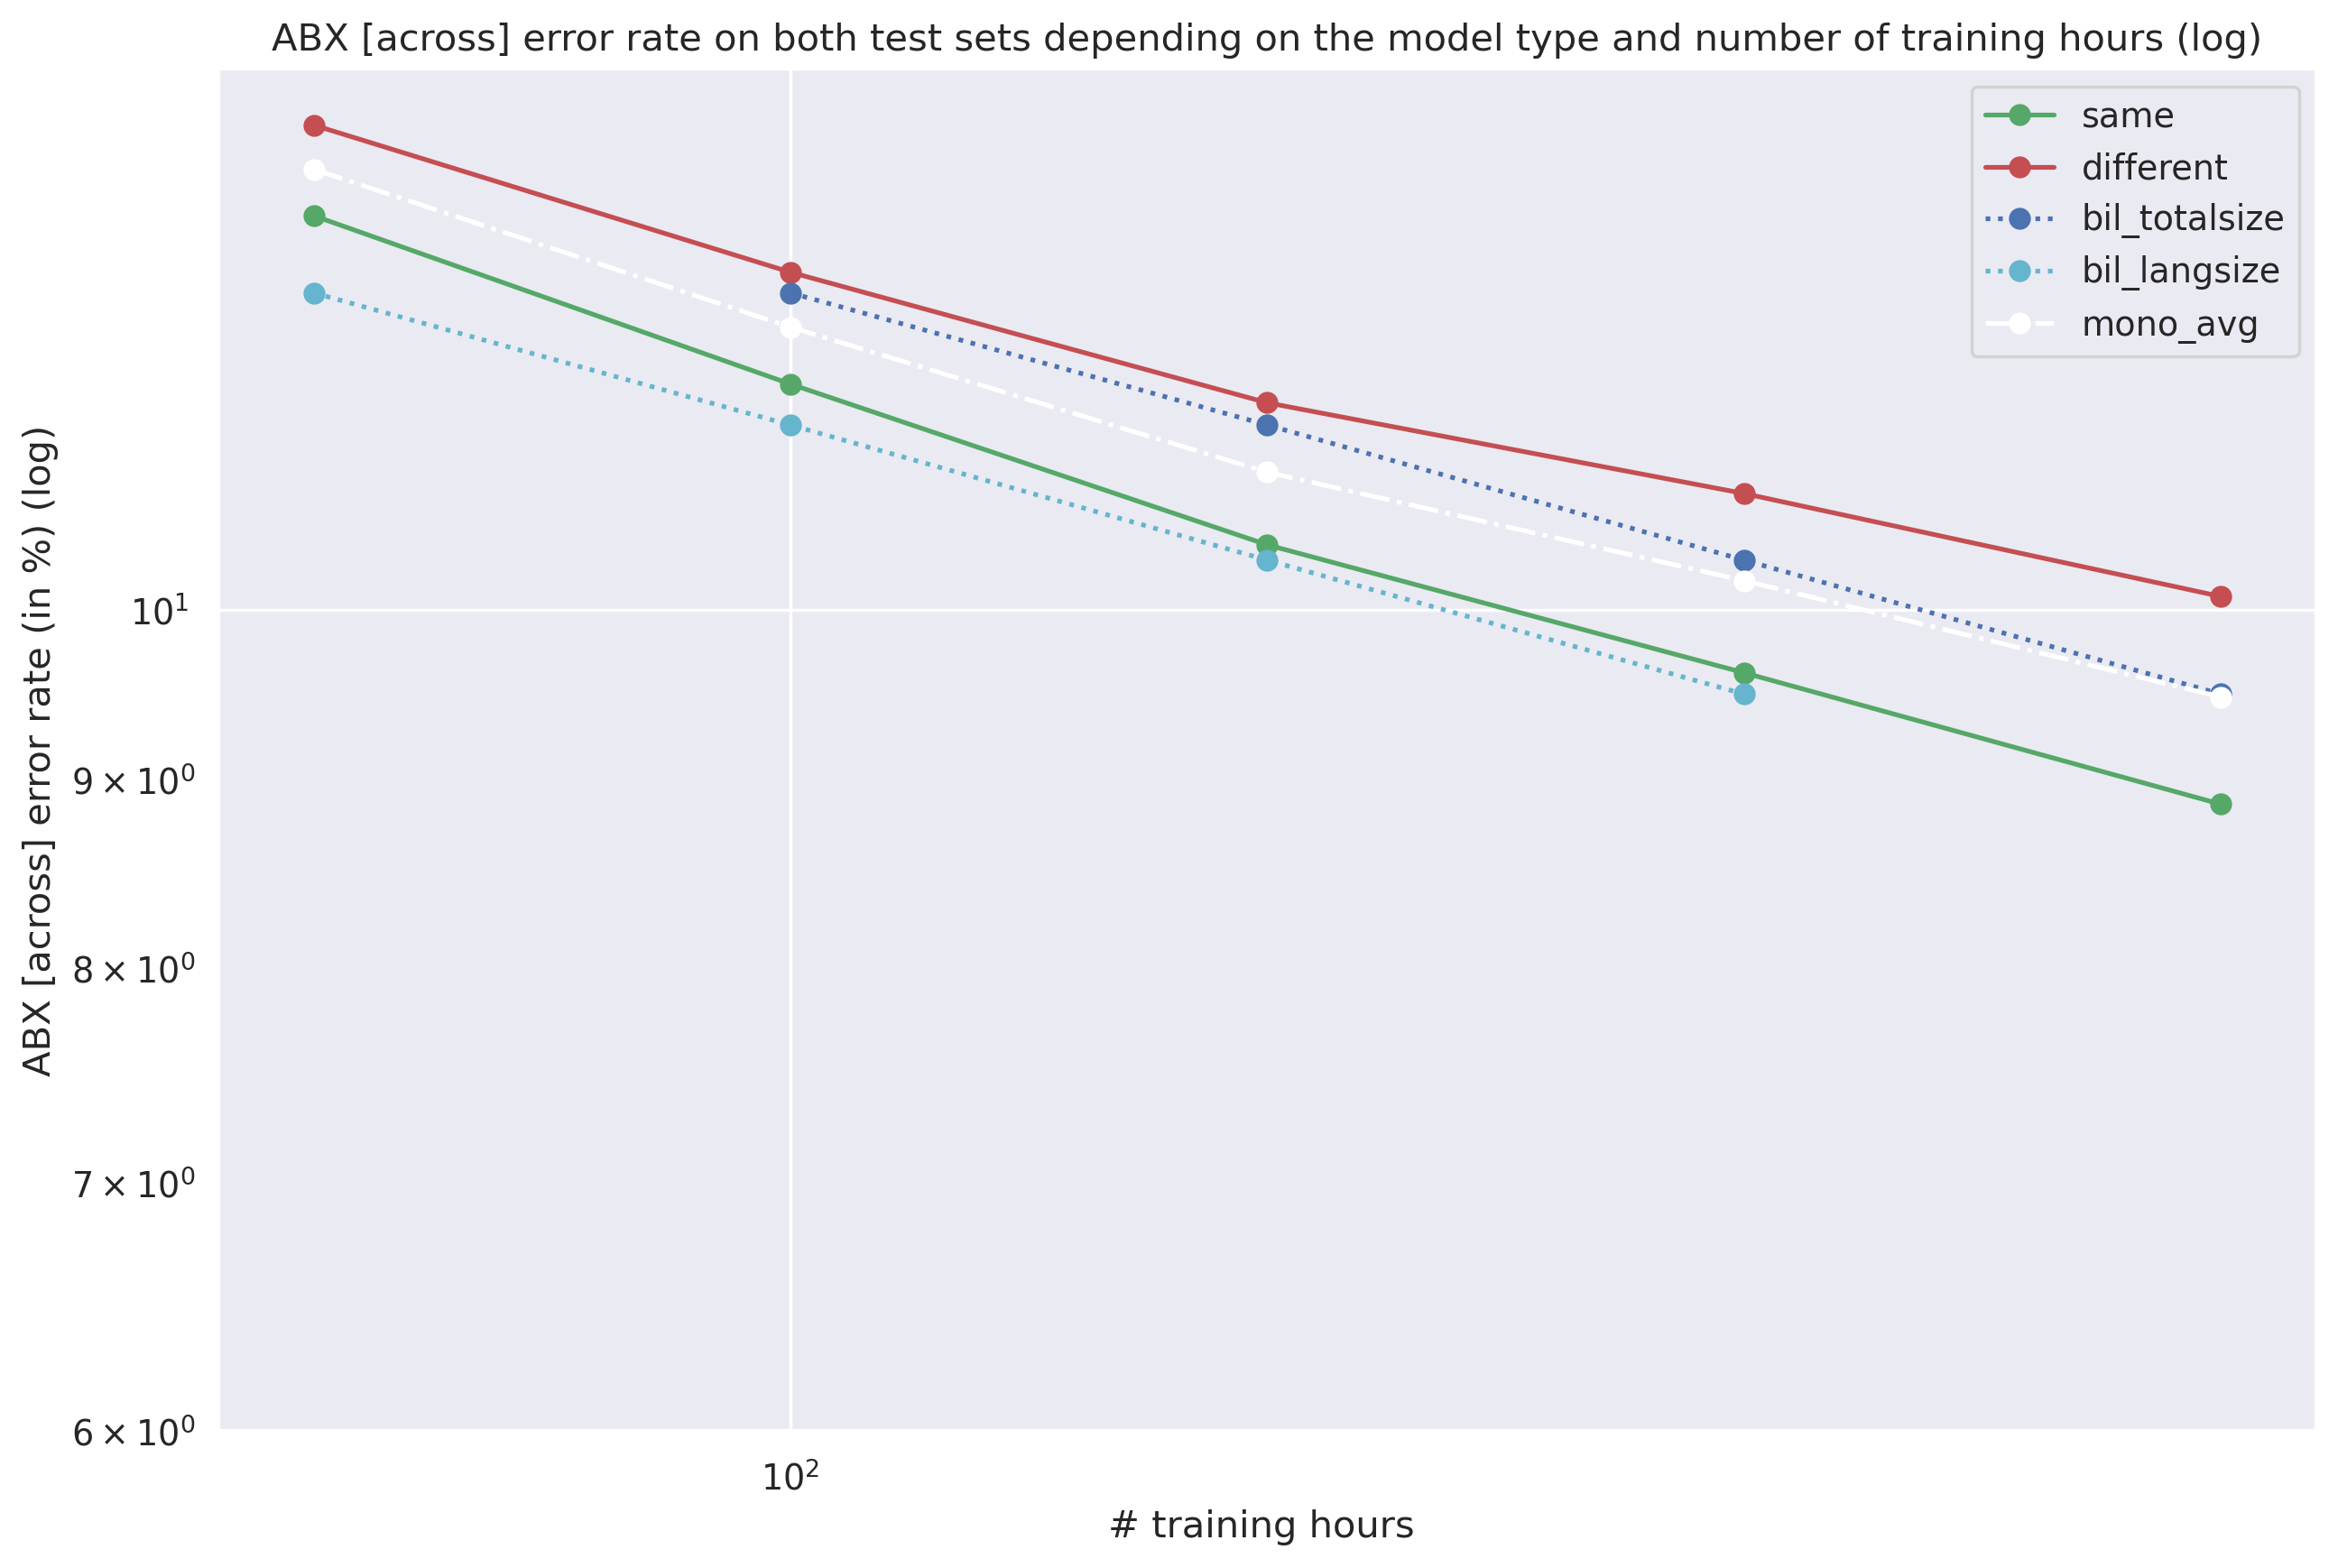

In [39]:
df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) (log)")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours (log)")
plt.ylim([6,14])

### D3a. Developmental [within] ABX  on the French test set 

Text(0.5, 1.0, 'ABX [within] error rate on the FRENCH evaluation set')

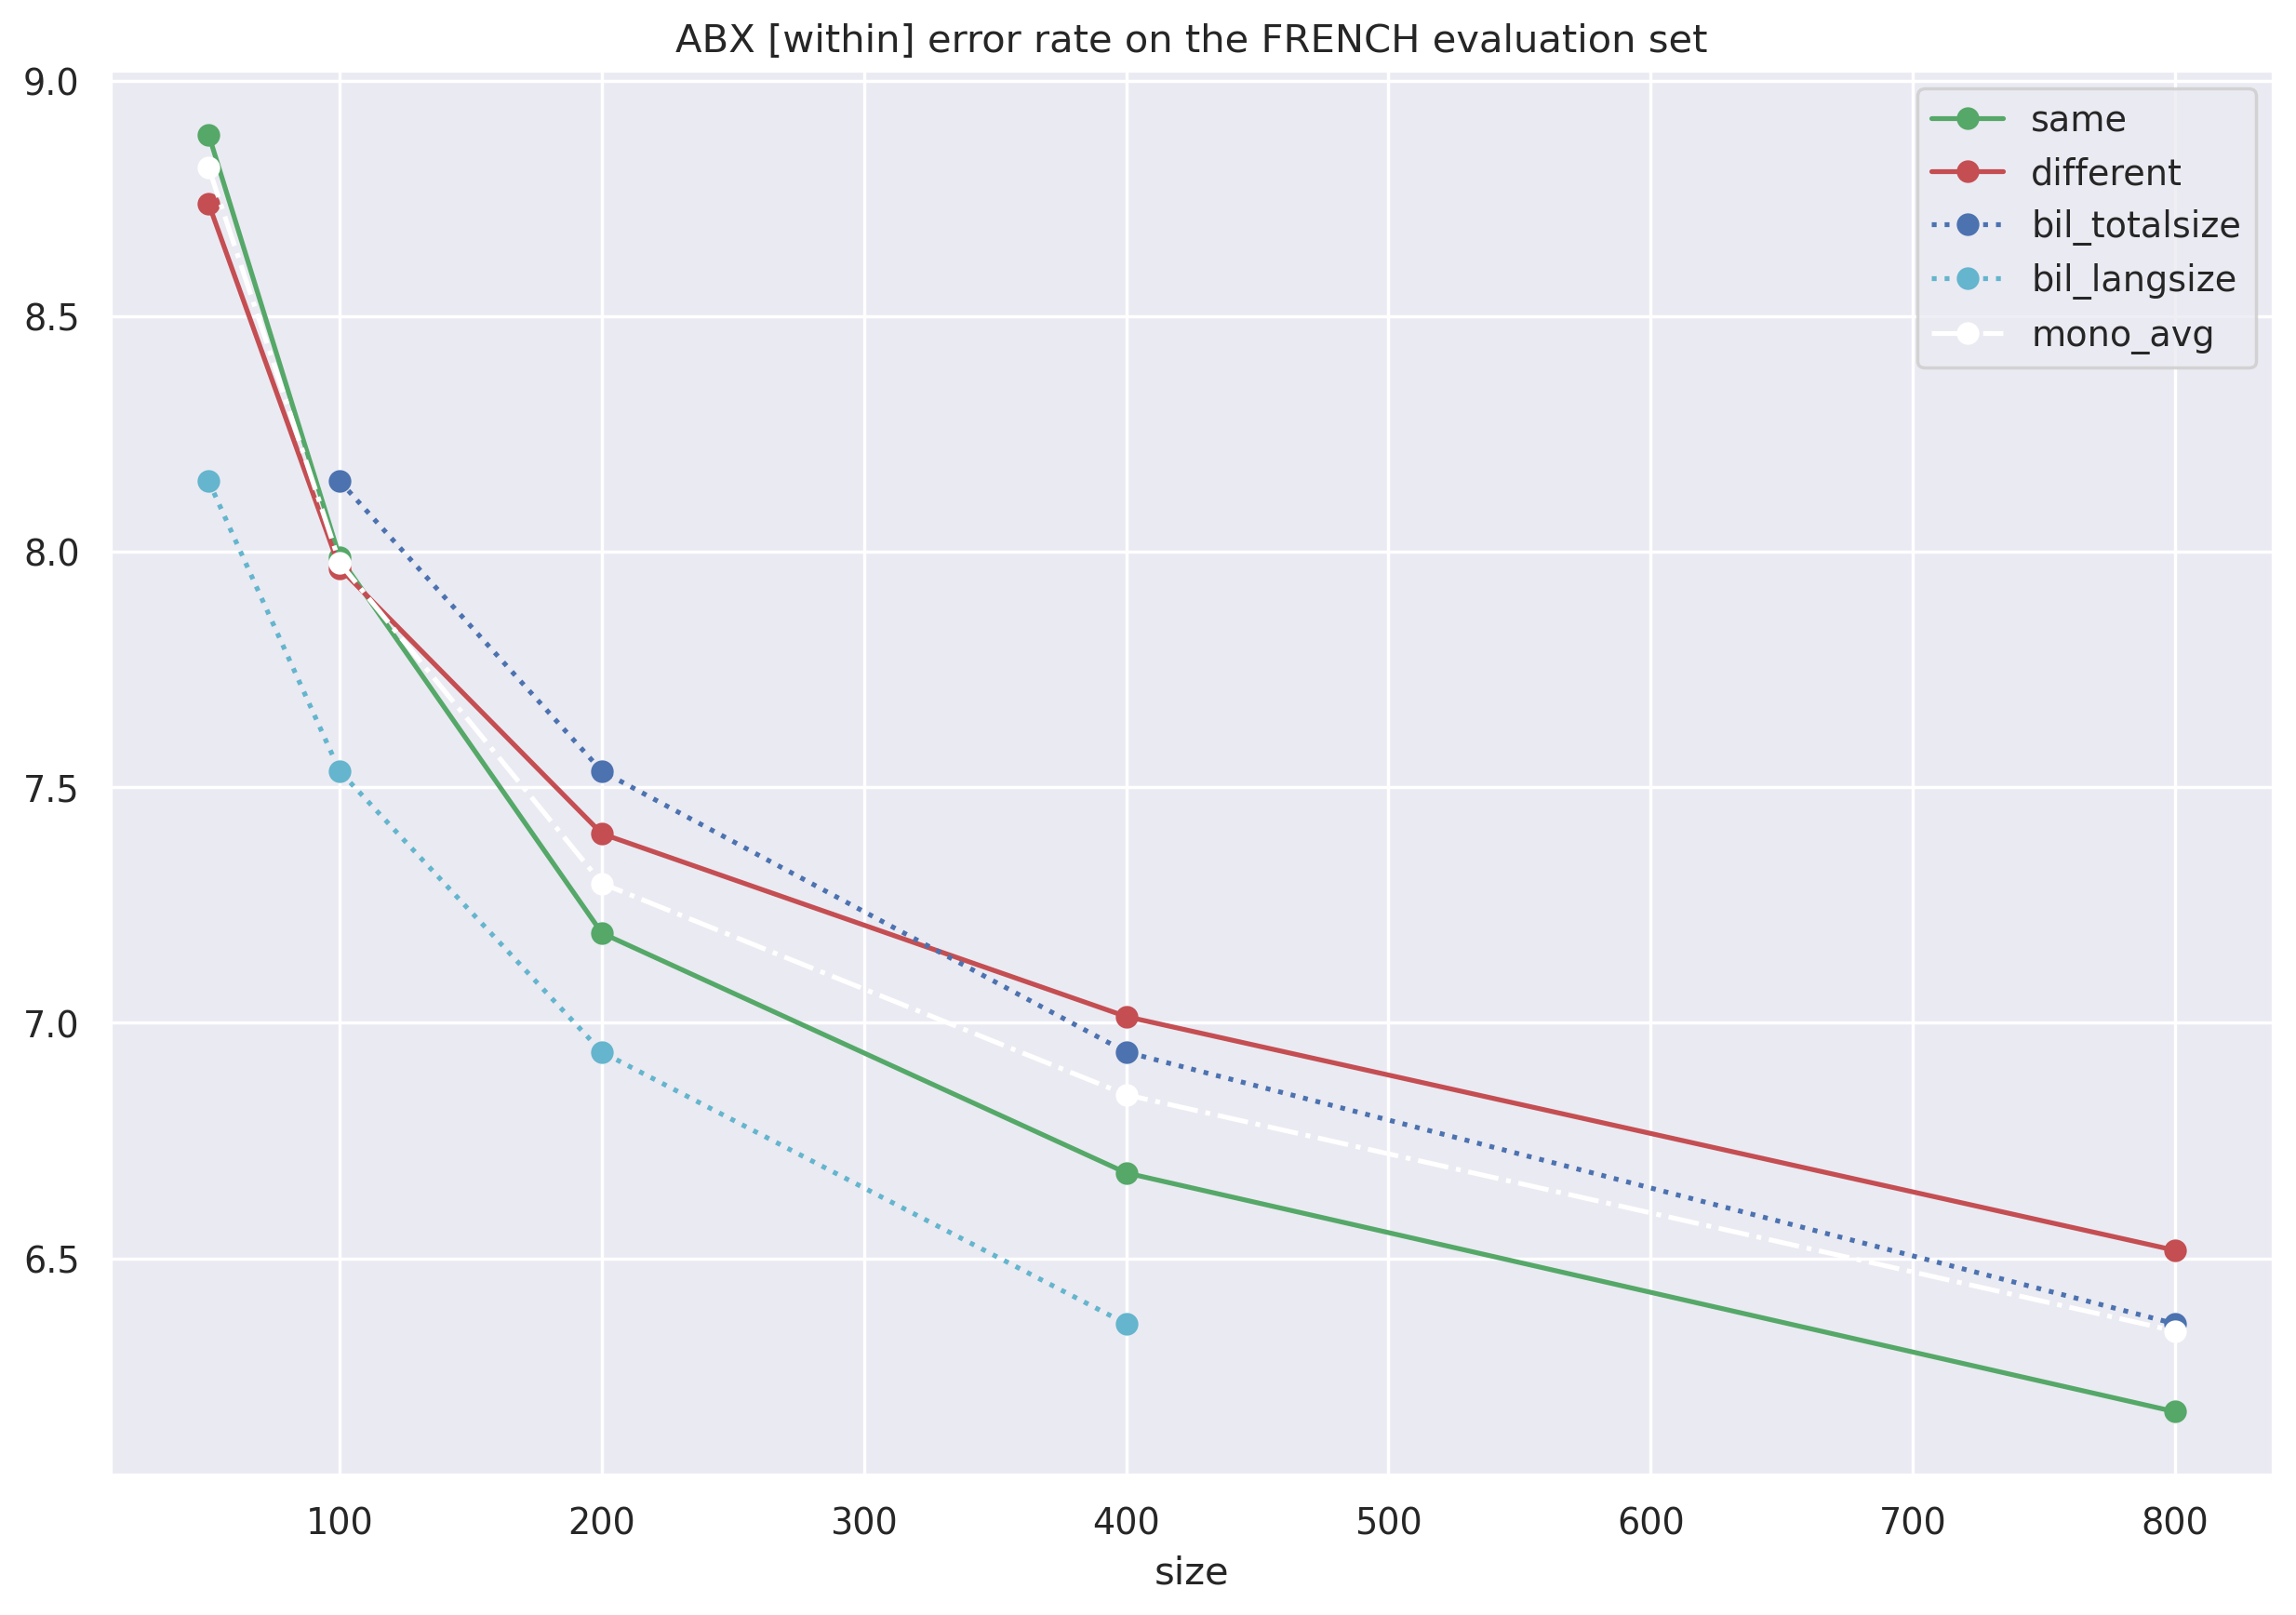

In [17]:
l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate on the FRENCH evaluation set")


### D3b. Developmental [within] ABX  on the French test set (original and QuickFix) - xLog scale

Text(0, 0.5, 'ABX [within] error rate')

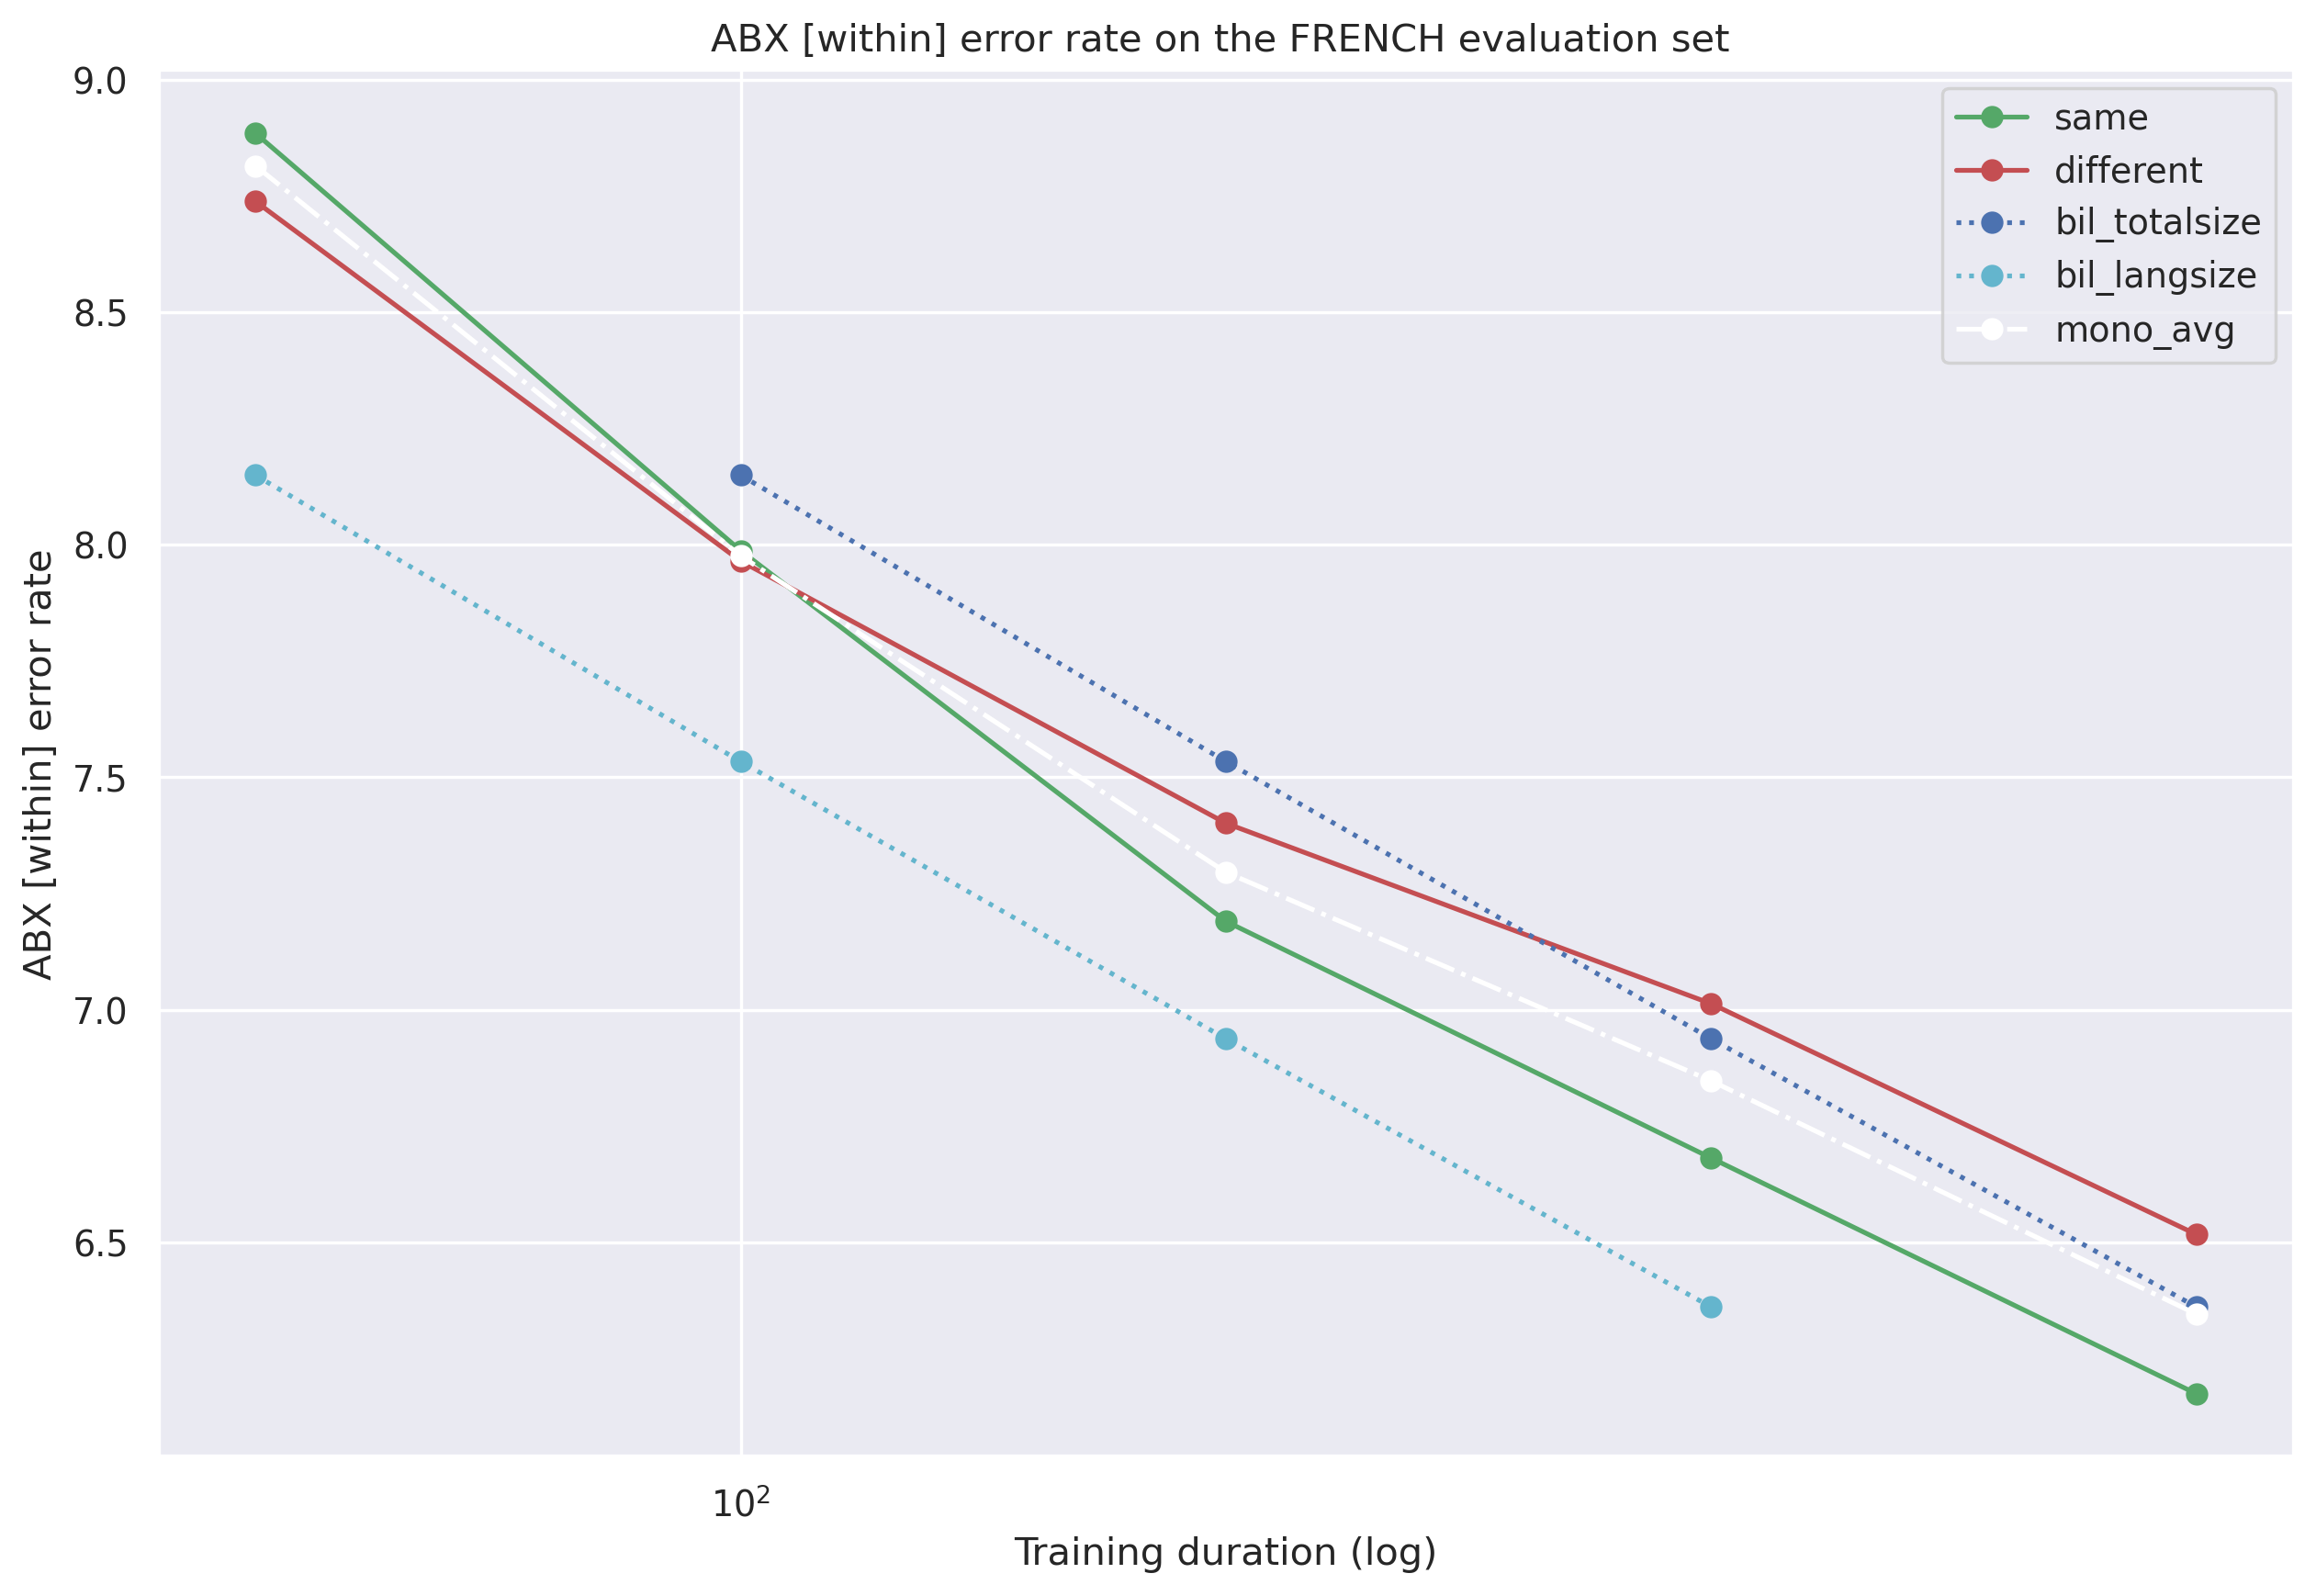

In [31]:
#log

l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, logx=True)
plt.title("ABX [within] error rate on the FRENCH evaluation set ")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate")


### D3c. Developmental [within] ABX  on the French test set - Loglog scale

(6, 11)

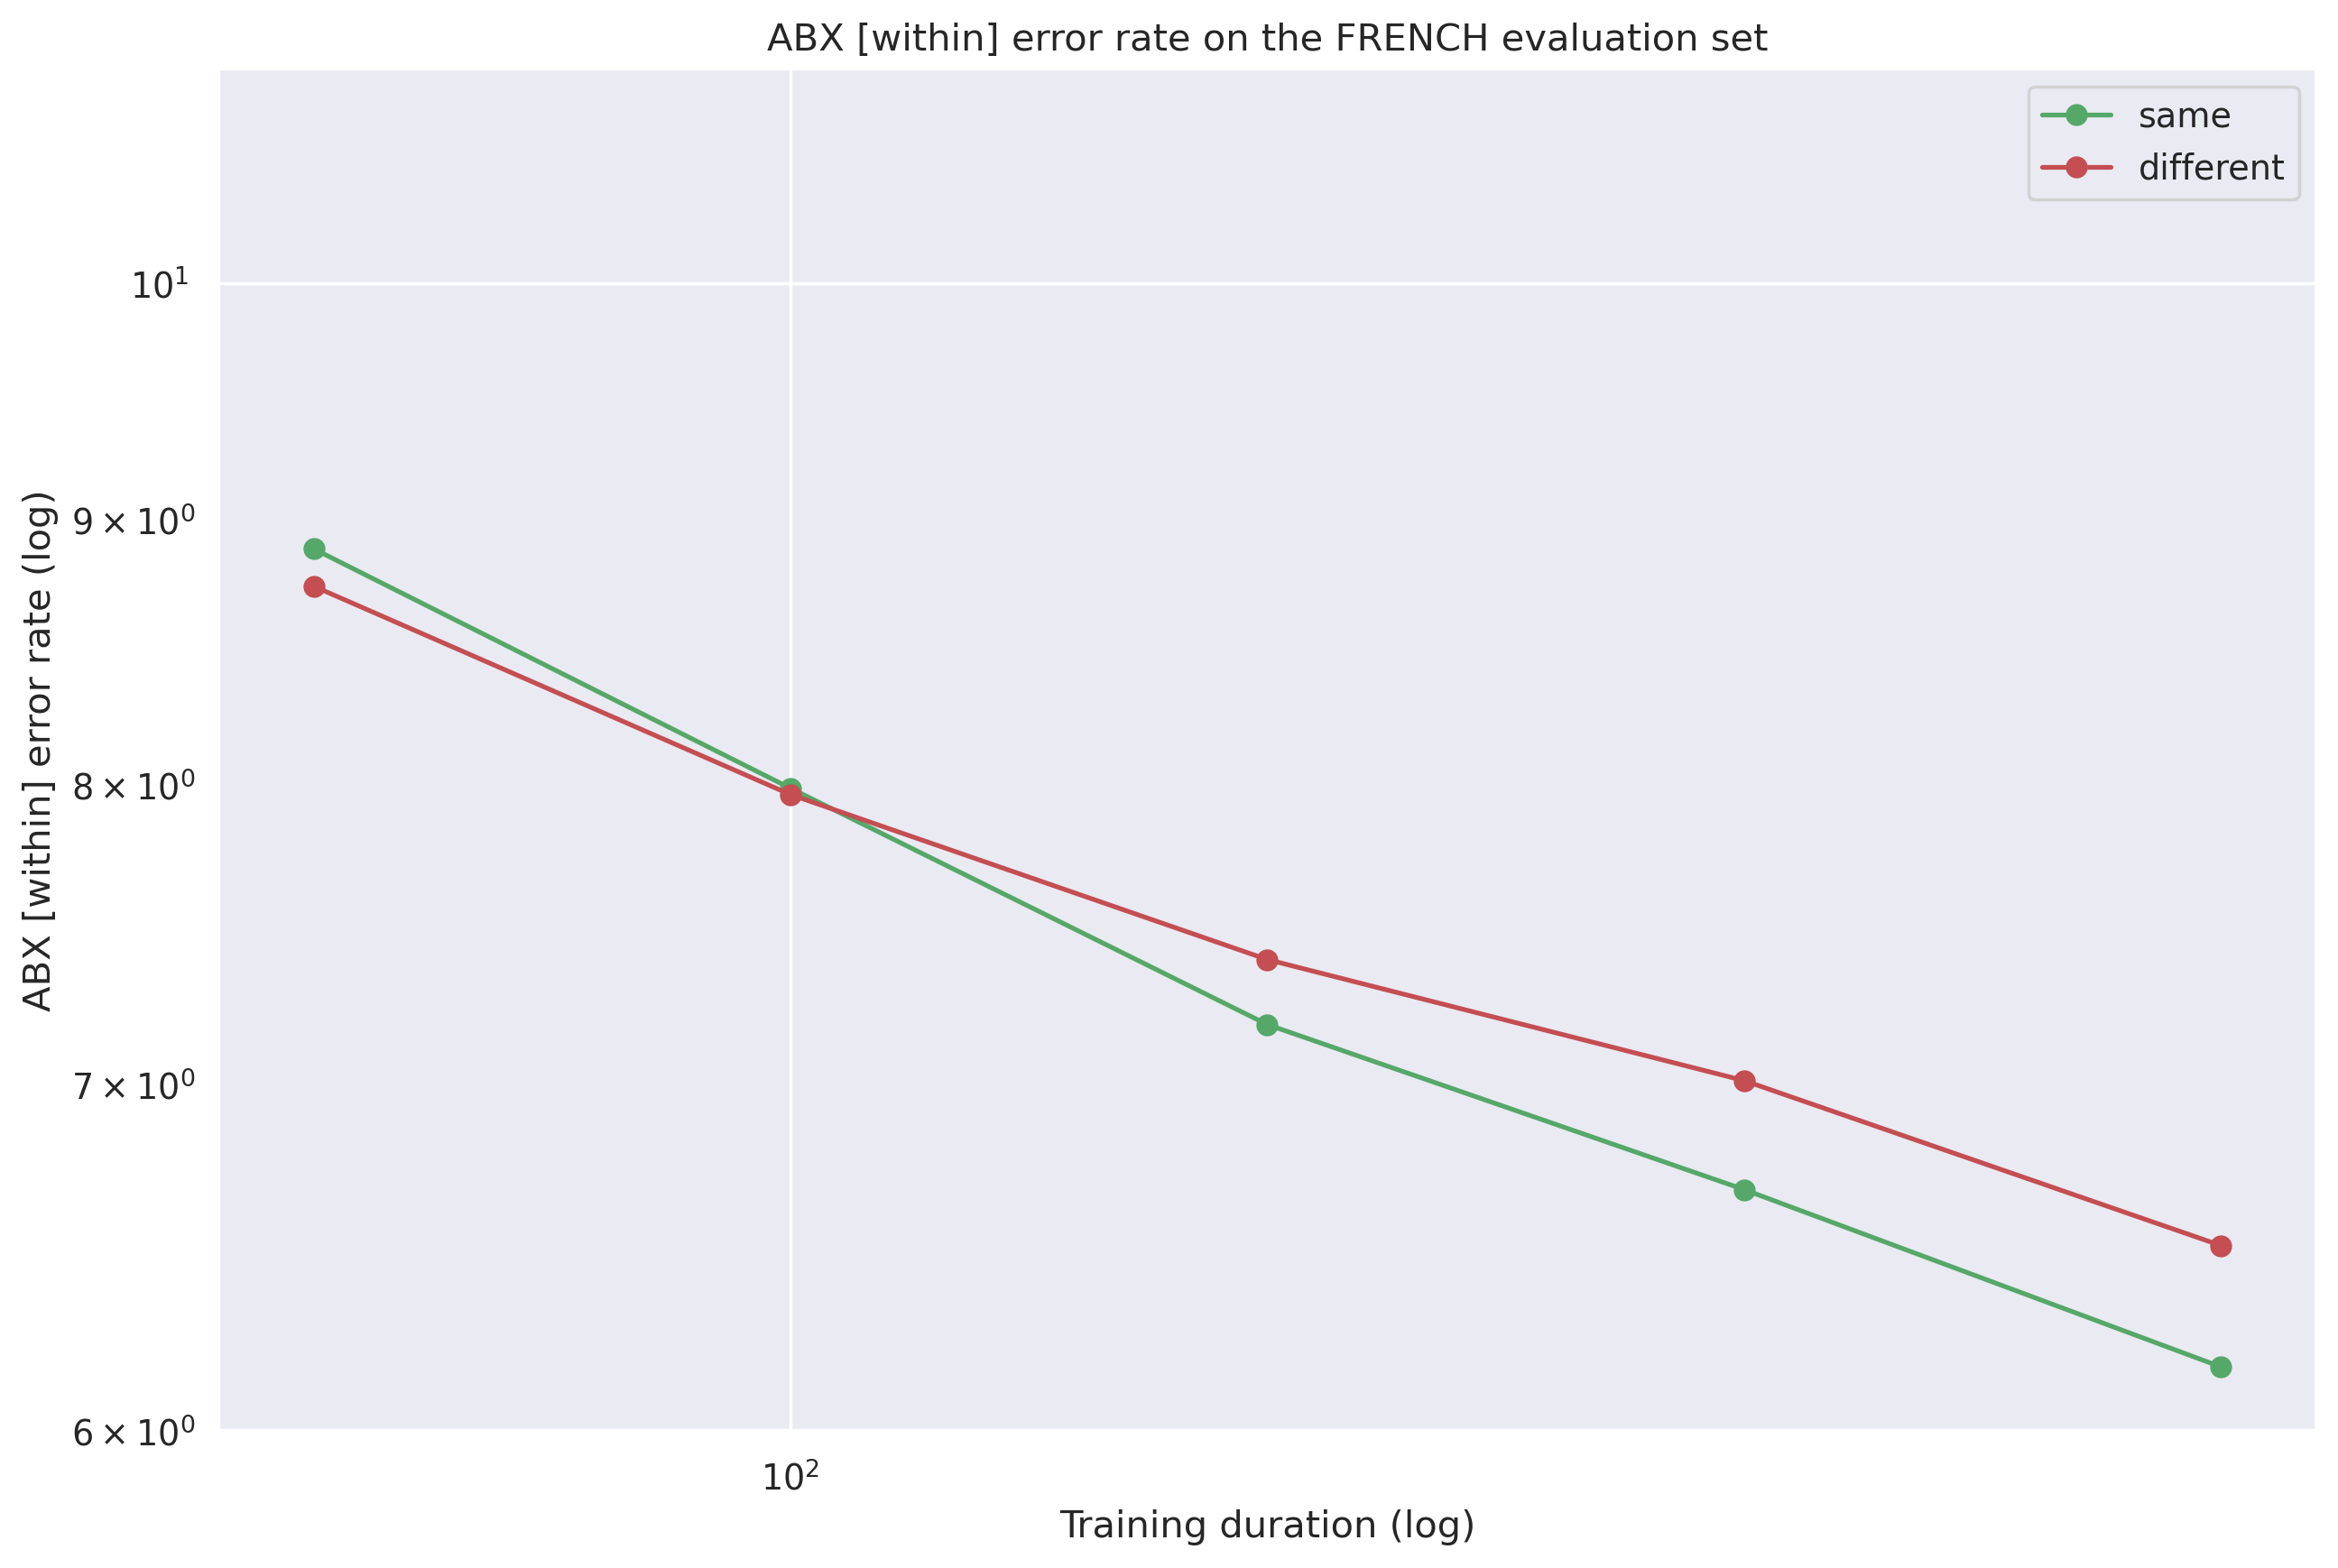

In [48]:
#log

l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([6,11])

### D4a. Developmental [within] ABX on the English test set

(6.0, 11.0)

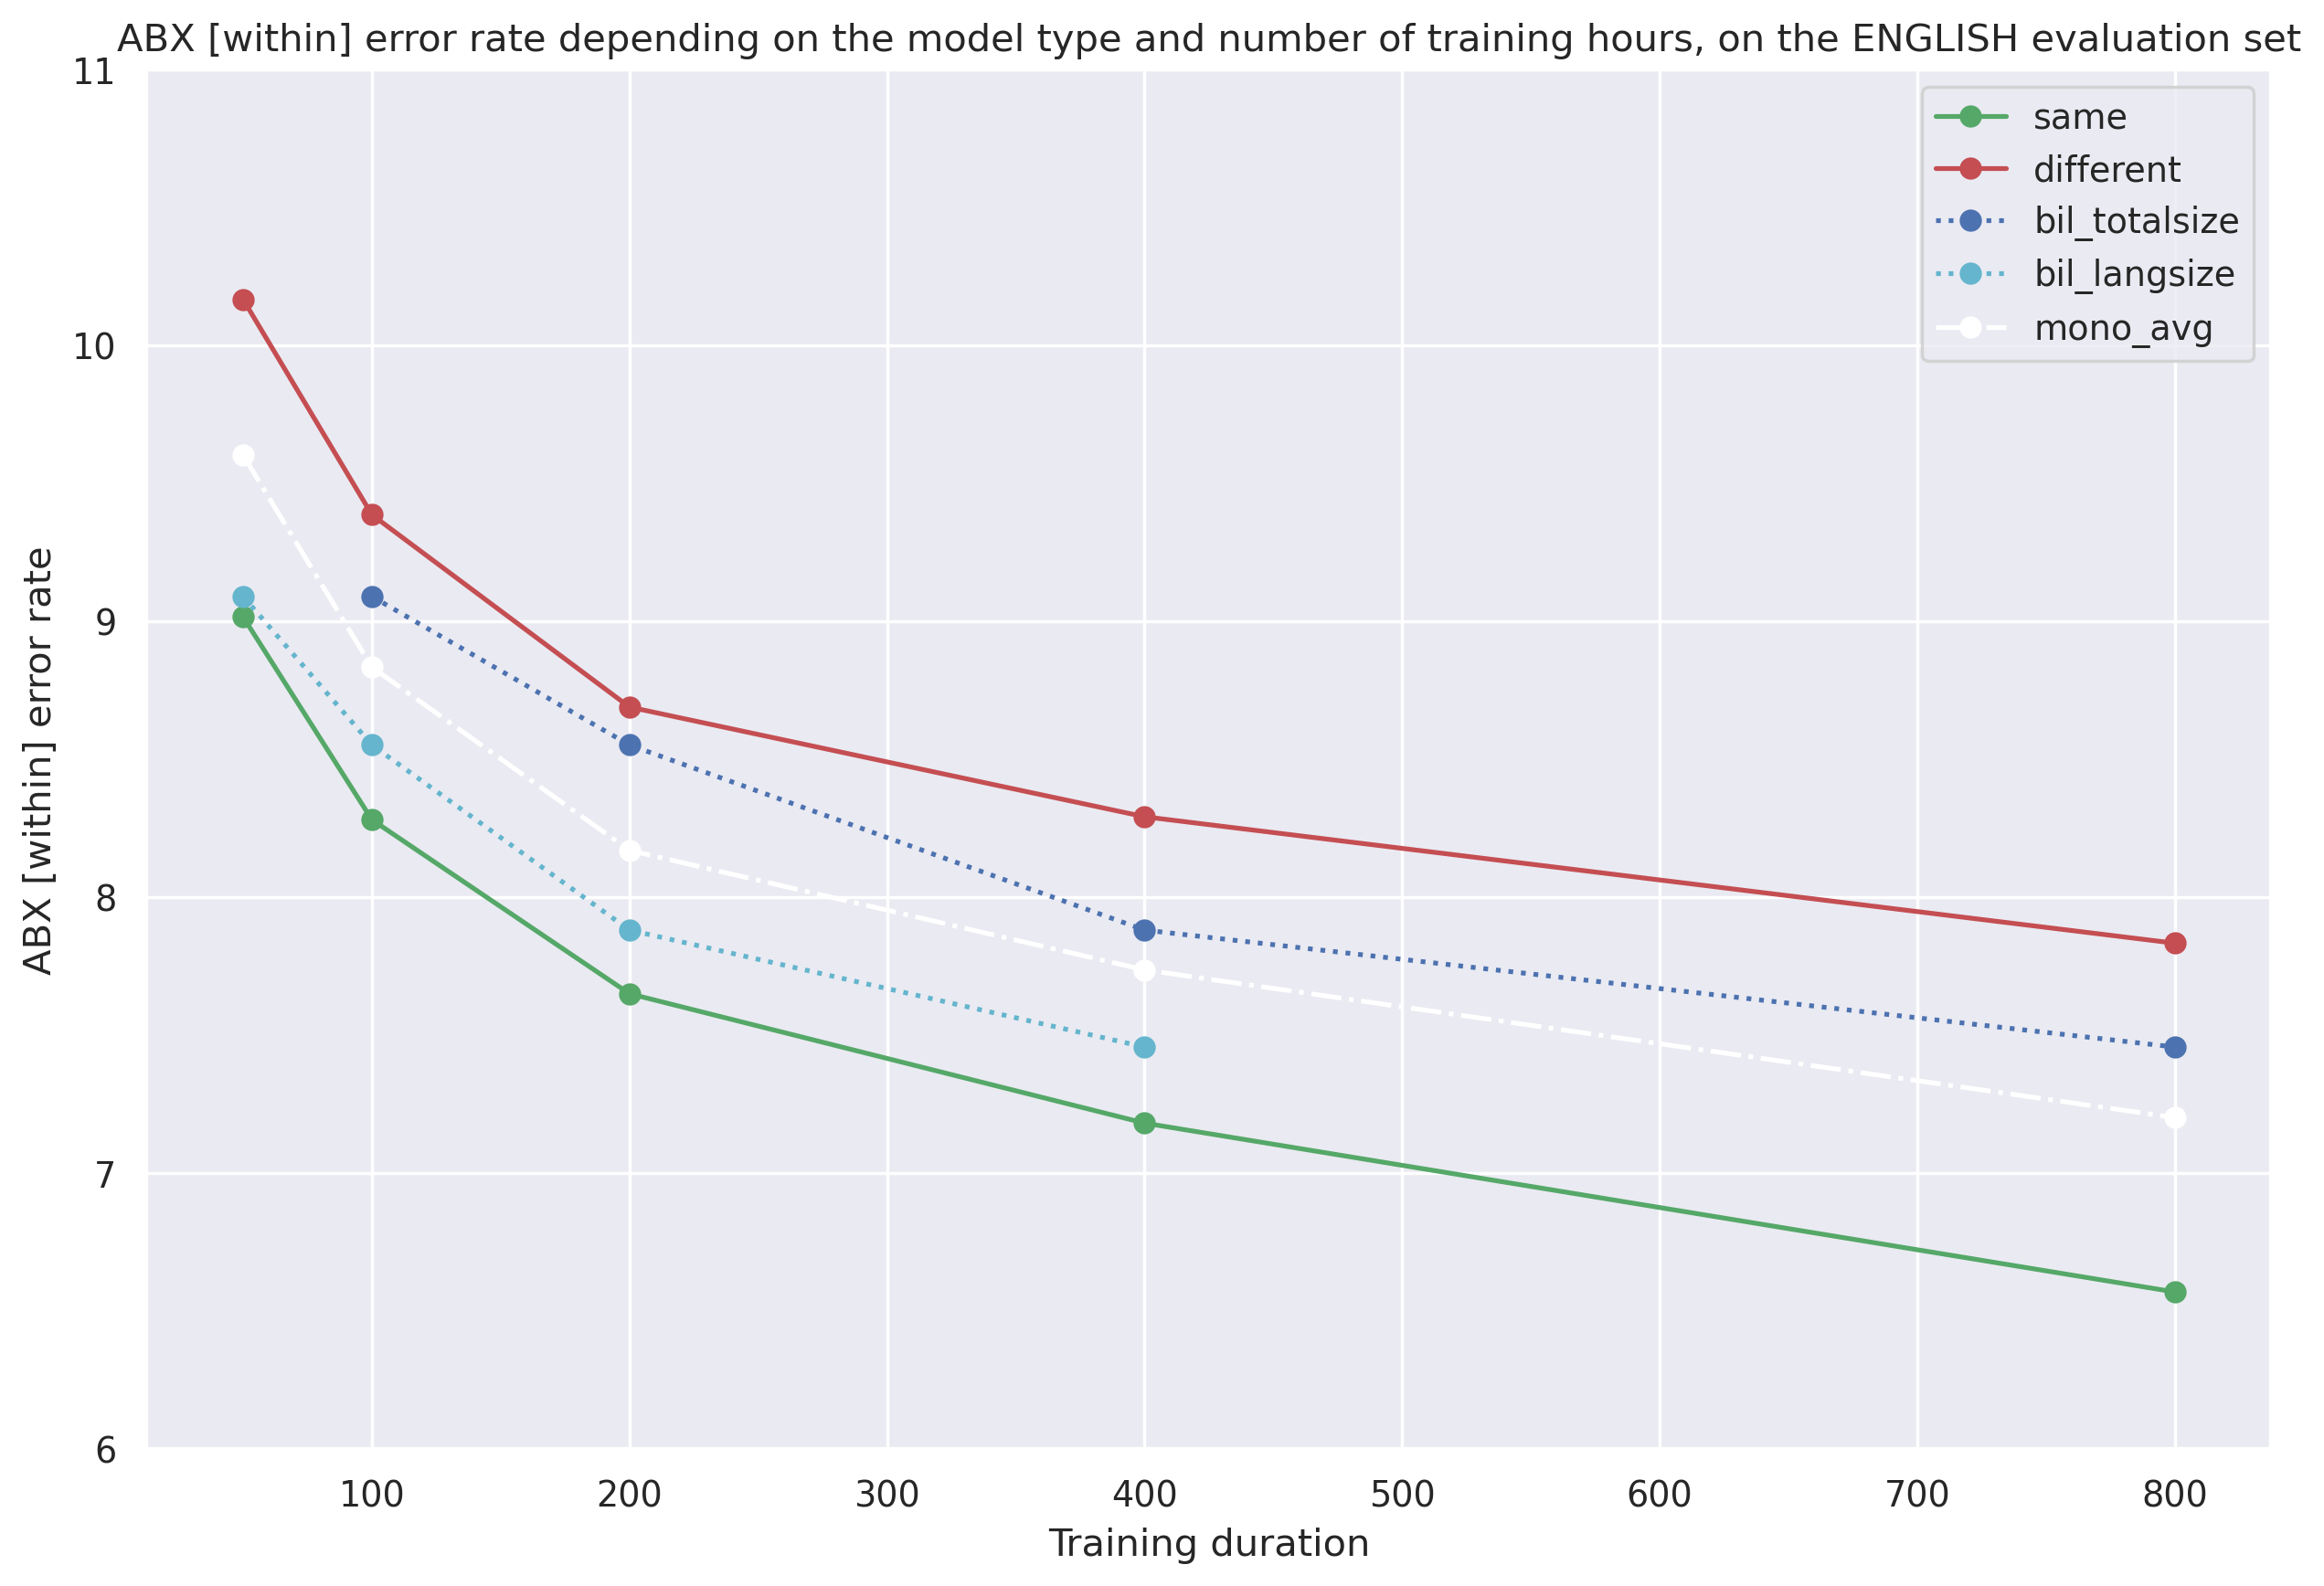

In [35]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate depending on the model type and number of training hours, on the ENGLISH evaluation set")
plt.xlabel("Training duration")
plt.ylabel("ABX [within] error rate")
plt.ylim([6,11])

### D4a. Developmental [within] ABX on the English test set - loglog scale

(6, 11)

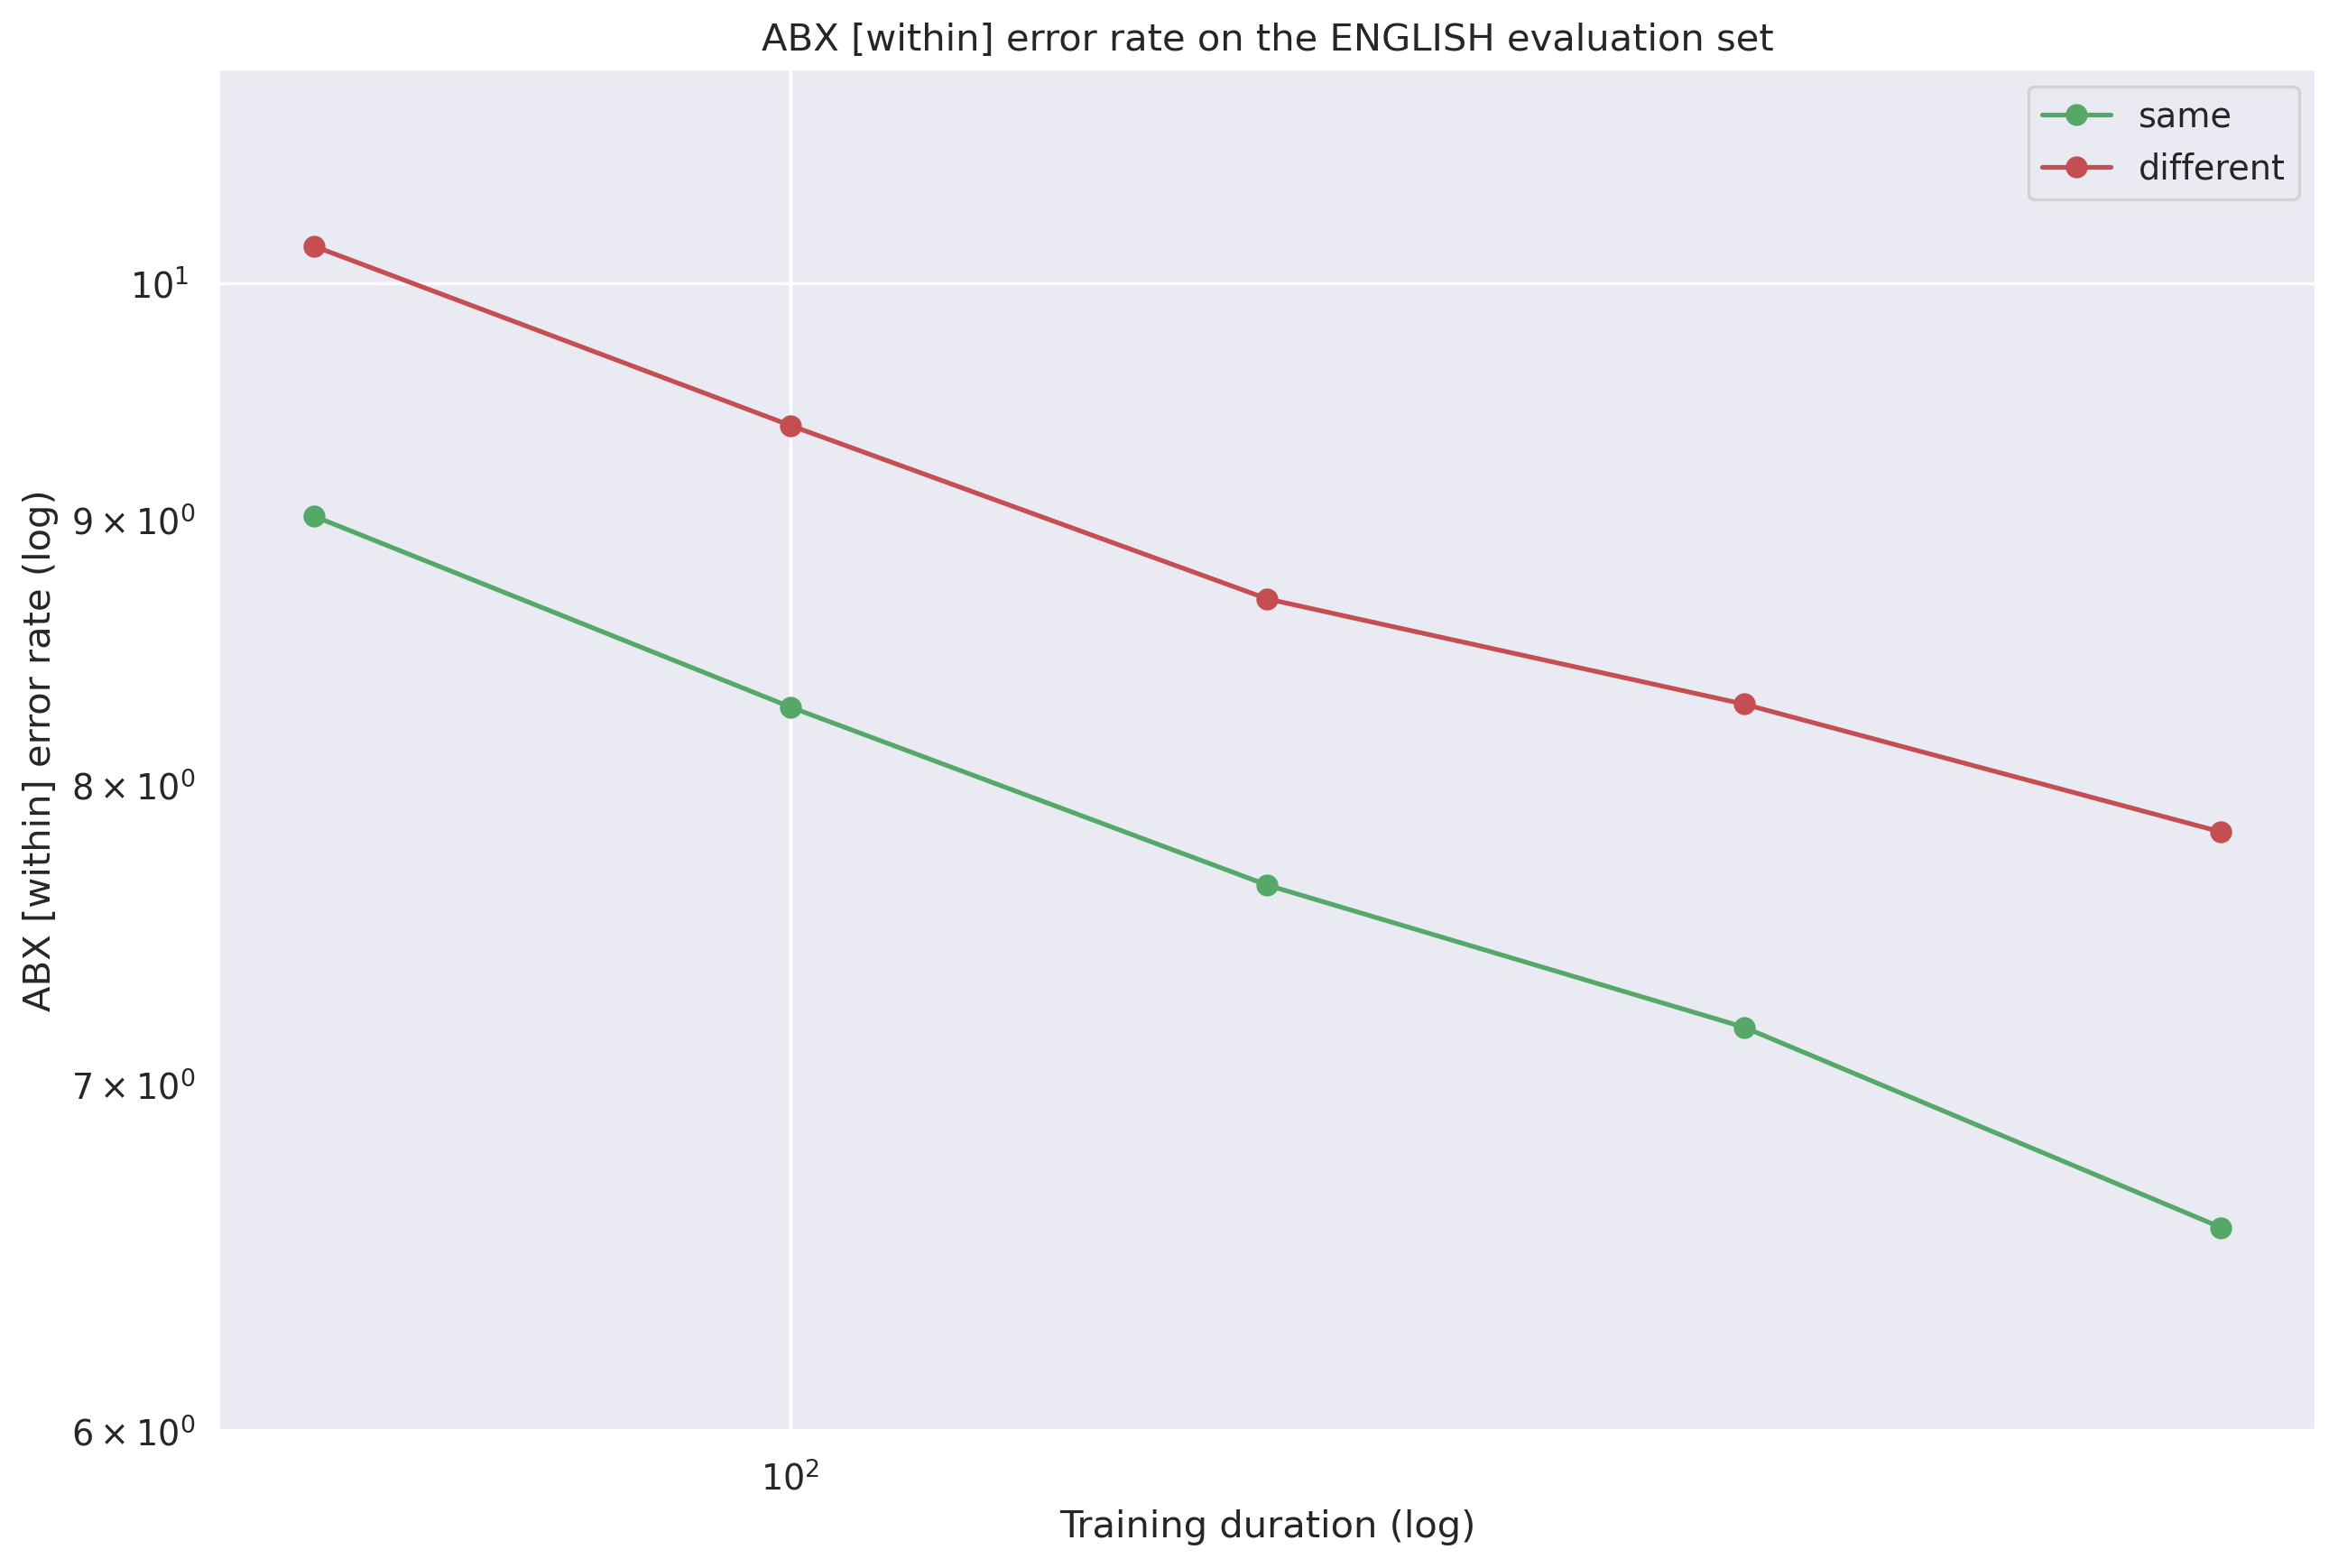

In [49]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([6,11])

### D5. Developmental [across] ABX  on the French test set (original and QuickFix) - LogLog

(8, 15)

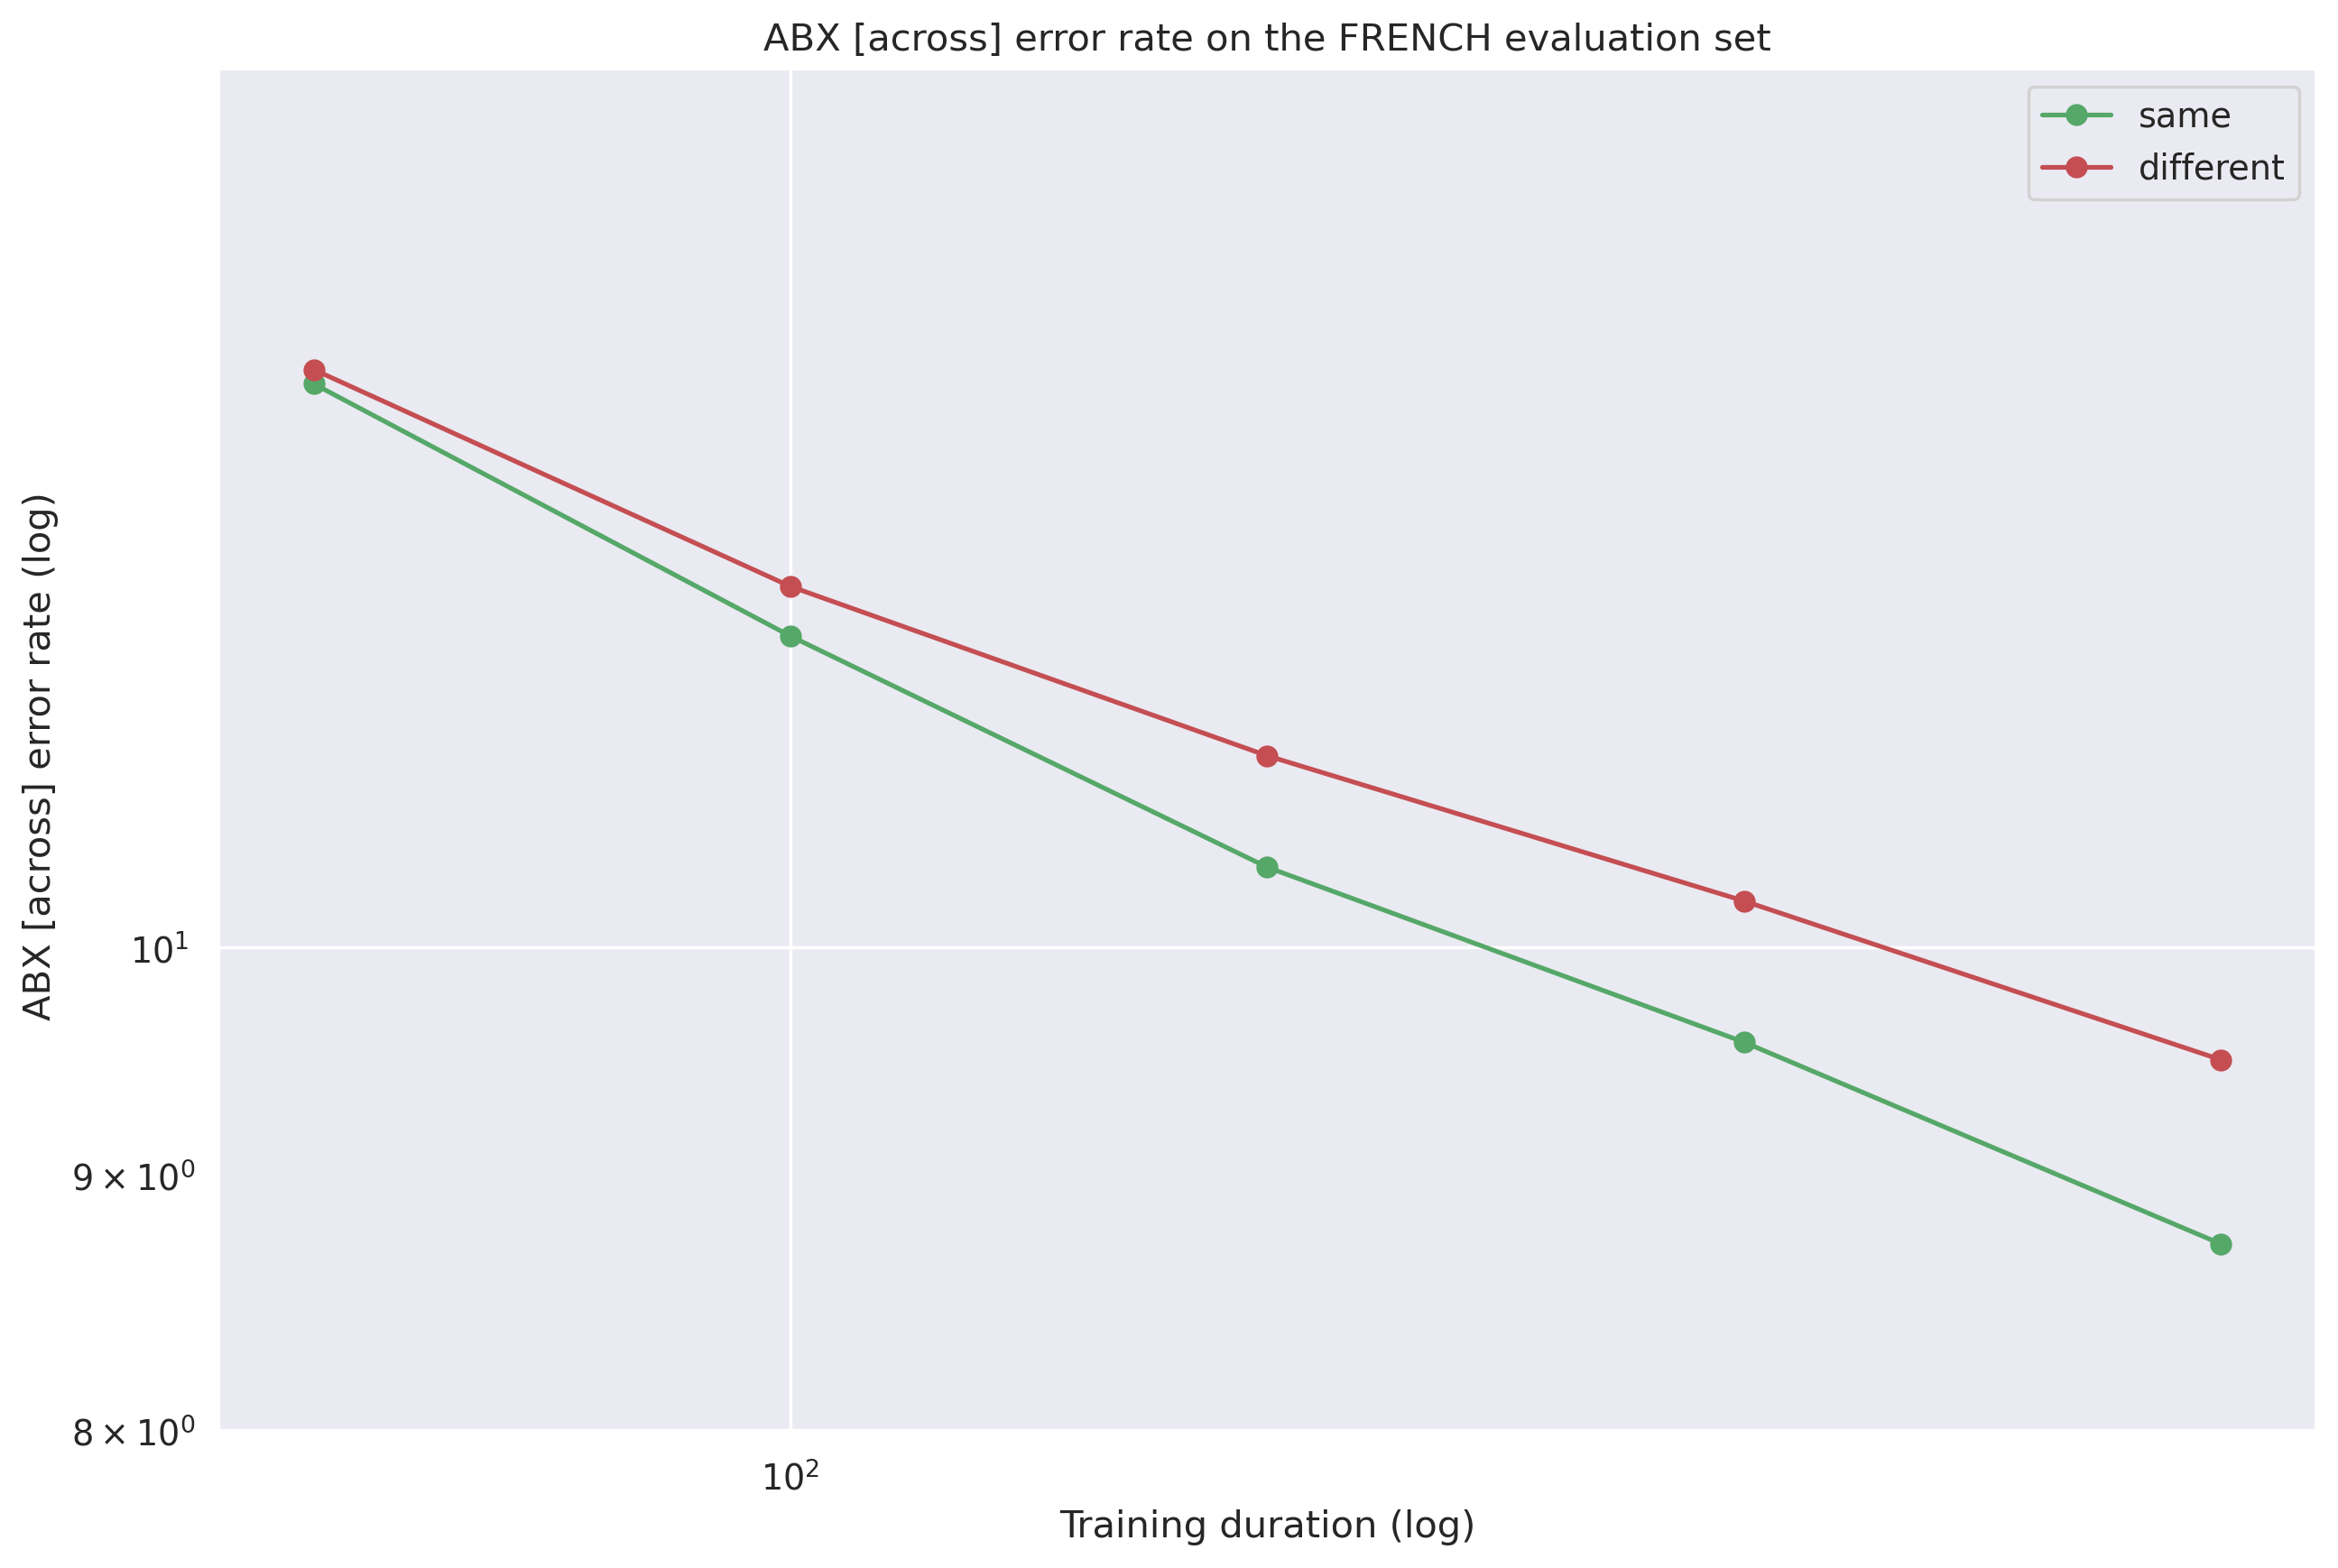

In [51]:
l="fr"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
plt.title("ABX [across] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log) ")
plt.ylim([8,15])


### D6. Developmental [across] ABX  on the English test set (original and QuickFix) - LogLog

(8, 15)

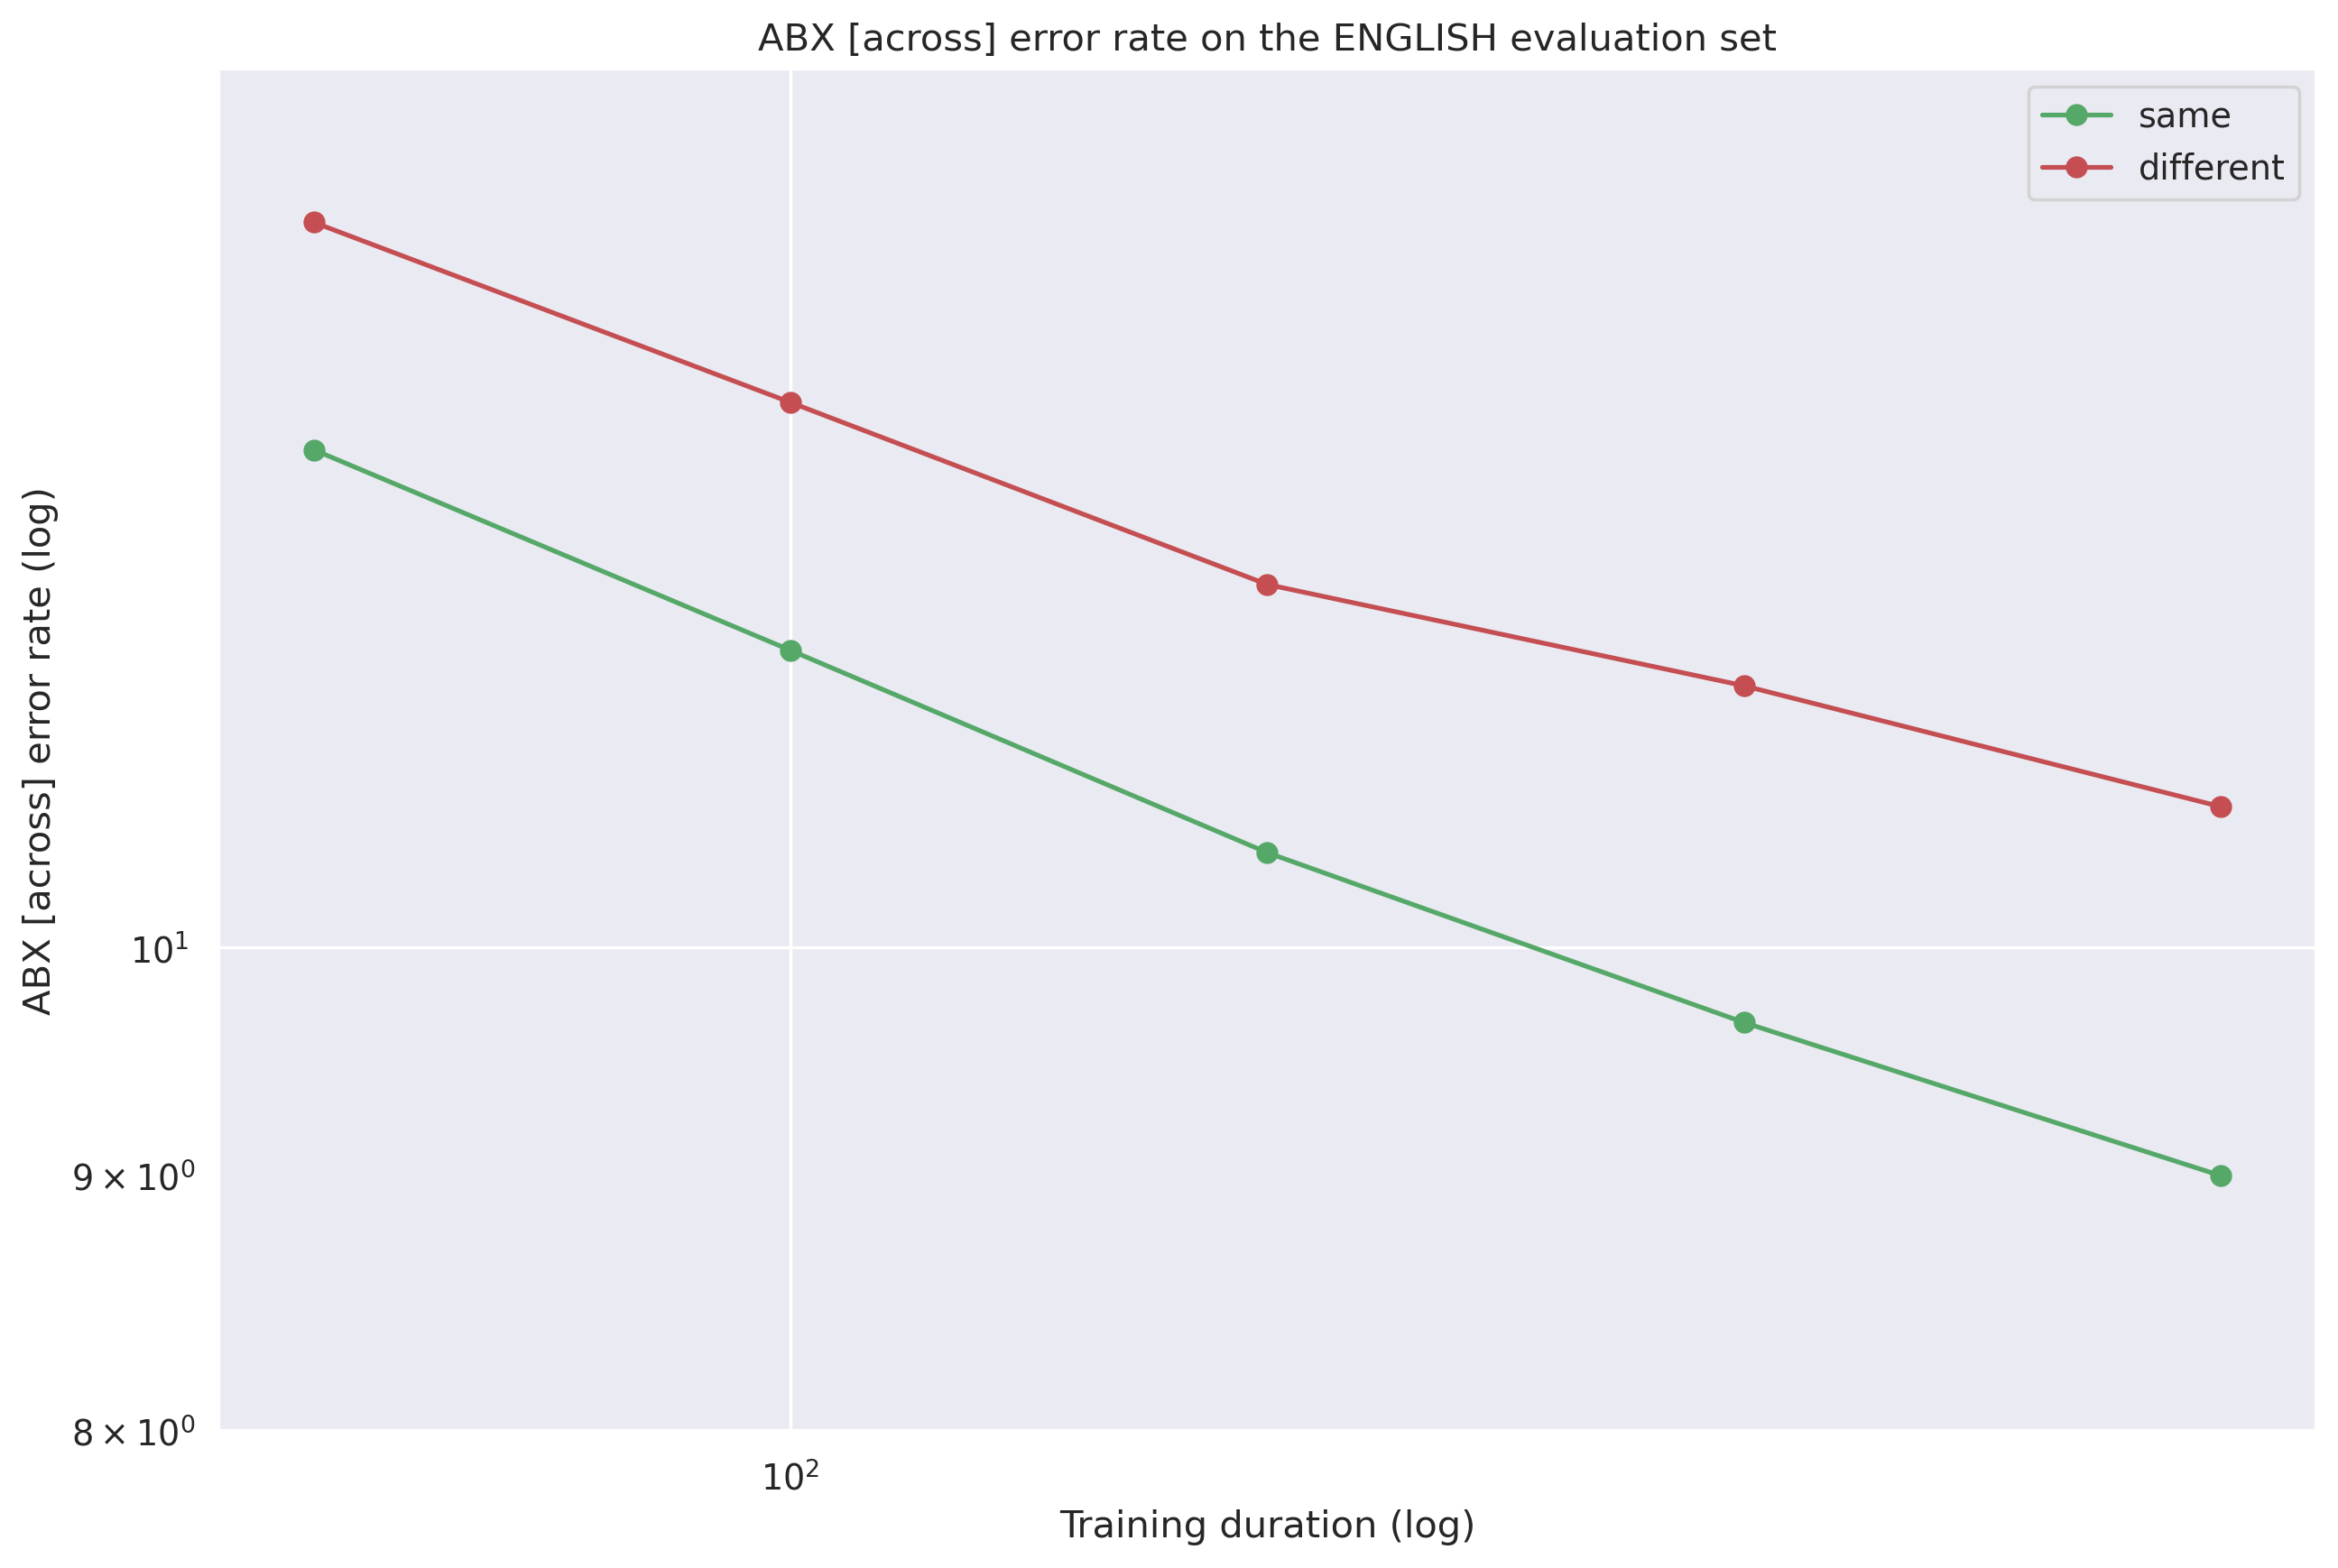

In [53]:
l="en"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)

plt.title("ABX [across] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log)")
plt.ylim([8,15])

###  Calculating Relative Advantage per data doubling :
Eg There is a **x** improvement when we double the data

In [54]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df

,en_model,fr_model,bil_totalsize_A,bil_totalsize_B,same,different,bil_langsize,bil_totalsize,mono_avg
size,,,,,,,,,
50,8.738385,8.885001,NaN,NaN,8.885001,8.738385,8.149565,NaN,8.814973
100,7.964873,7.987238,8.145074,8.154055,7.987238,7.964873,7.533759,8.149565,7.976055
200,7.401137,7.190205,7.561584,7.505935,7.190205,7.401137,6.937548,7.533759,7.295671
400,7.013016,6.681151,6.949032,6.926064,6.681151,7.013016,6.360897,6.937548,6.847083
800,6.516826,6.174240,6.371431,6.350363,6.174240,6.516826,NaN,6.360897,6.345533


In [55]:
df = df_within.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -8.137703798911478
different -6.664426396536197
bil_langsize -7.107803012736672
bil_totalsize -7.107803012736672


In [56]:
df = df_across.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -8.739203932397587
different -7.059360834416089
bil_langsize -7.9822691945048065
bil_totalsize -7.9822691945048065


In [57]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -8.687522378815459
different -7.062254065961575
bil_langsize -7.927394790304862
bil_totalsize -7.927394790304862


In [58]:
l="en"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -7.603673371829361
different -6.300189480306796
bil_langsize -6.38166350924363
bil_totalsize -6.38166350924363


In [59]:
l="fr"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -9.436992033339818
different -7.646351730317793
bil_langsize -8.75898185509675
bil_totalsize -8.75898185509675


In [60]:
l="en"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -8.029383865657579
different -6.506780231939399
bil_langsize -7.247995739669218
bil_totalsize -7.247995739669218
